# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook - good example how to add TabPFN
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric - good guide on creating custom metric in Keras
- https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/410139 - overall notes about similar competitions

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )
- [x] CV TabPFN - looks even inferior to GBT. May be due to preprosessing.
- [x] Ensembled into Submition results from several Classifiers (There is aa room for Playing with manually assigned weights)
- [x] Due to time consideration -> SUBMITION: bool
- [x] Submition Error When calculating results.
- [x] Rethink CV (check dimension) v31->v32,
- [x] Solve problem with accuracy (showns NaNs) -> Changed to Binary Accuracy version
- [x] Solved problem with NaNs in metric -> min/max vals less than 1 more than 0, as in competrion calculator
- [x] loss: 0.0000e+00. Why ? Is it OK ? -> Yes it is okey. https://discuss.tensorflow.org/t/tfdf-custom-loss/2223
- [ ] Research wheather it is possible to train with respect to Gradient of the metric.
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [ ] Ensemble Results by some model:
    - Currently Simple Manual Weights, which may be more optimal. Need to make some grid and choose the best.
    - I use Mean for Each CV Branch, may-be also grant some threshs or weights
    - [x] Refactored each Model Estimation to result into Train/Valid/Test Frames
- [ ] Cutoffs
    - https://medium.com/swlh/determining-a-cut-off-or-threshold-when-working-with-a-binary-dependent-target-variable-7c2342cf2a7c
    - Find Lower/Upper Bounds which maximises competition metric
- [ ] May be try several CVs
- [ ] May be play with uplift to lessen features input
    

In [1]:
SUBMITION = False

## Install TabPFN offline

In [2]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [3]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [4]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

import joblib
import os
import shutil
import itertools

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [5]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [6]:
mining_columns: list = [i for i in dataset_df.columns if i not in ["Id","Class"]]

def compute_basic_stats(columns: list, df: pd.DataFrame) -> pd.DataFrame:
    
    out: dict = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

# Train
basic_stats_1 = compute_basic_stats(columns=mining_columns, df=dataset_df)

basic_stats_1.to_pickle('/kaggle/working/basic_stats_1.pickle')

# Inference
# basic_stats_1 = pd.read_pickle('/kaggle/working/basic_stats_1.pickle')

  0%|          | 0/56 [00:00<?, ?it/s]

In [7]:
basic_stats_1

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU,253,0.2,float64,0.26,0.005518,161.355315,9.034721,1.8029,5.55868
BC,259,0.0,float64,0.16,1.2299,1463.693448,65.166943,8.053012,5.724924
AF,599,0.0,float64,0.3,192.59328,28688.18766,2300.322717,3502.013221,5.900177
EH,127,0.0,float64,0.18,0.003042,42.569748,1.847499,0.305107,5.900177
AM,605,0.0,float64,0.24,3.177522,630.51823,69.728226,38.968552,5.900177
FD,337,0.0,float64,0.13,0.29685,1578.654237,64.754262,6.930086,5.900177
DI,571,0.0,float64,0.26,60.23247,1049.168078,86.084419,146.972099,5.900177
FR,435,0.0,float64,0.1,0.49706,1244.22702,50.181948,3.533905,5.900177
AB,217,0.0,float64,0.28,0.081187,6.161666,0.468388,0.477149,6.017012
CF,586,0.0,float64,0.11,0.510888,200.967526,13.571133,11.241064,6.192265


* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [8]:
WoE_Columns = ['DU', 'BC', 'AF', 'EH', 'AM', 'FD', 'DI', 'FR', 'AB', 'CF', 'BZ', 'FE', 'AX', 'BR',
               'GB', 'AY', 'FC', 'FS', 'CC', 'GH', 'DV', 'DY', 'EE', 'GE', 'AH', 'DN', 'EP', 'EU',
               'EG', 'FI', 'DH', 'GF', 'GI', 'DE', 'DA', 'CW', 'CU', 'AZ', 'CL', 'CH', 'BD', 'BN',
               'DL', 'CS', 'FL', 'GL', 'CB', 'DF', 'BP', 'EB', 'AR', 'CD', 'EL', 'CR', 'BQ']

In [9]:
def preprocess_train(train: pd.DataFrame, numeric_features: list, save_path: str) -> None:
    woes = dict()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train[i], y=train['Class'])
        woes[i] = tmp_woe
    
    # Save WoE
    _ = joblib.dump(value=woes, filename=save_path)
    print('Saved features: ', save_path)
    
    return None

def preprocess_inference(train: pd.DataFrame, test: pd.DataFrame, 
                         numeric_features: list,
                         stats: pd.DataFrame, save_path: str) -> (pd.DataFrame, pd.DataFrame, list):
    info = dict()
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    woes = joblib.load(save_path)
    
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        train_out[i + '_WoE'] = woes[i].transform(X=train_out[i])
        test_out[i + '_WoE'] = woes[i].transform(X=test_out[i])
        out_features.append(i + '_WoE')
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features


# Only for Train
_ = preprocess_train(train=dataset_df, numeric_features=WoE_Columns, save_path='/kaggle/working/WoE.pickle')

# For Train & Inference
train_out,test_out,features = preprocess_inference(train=dataset_df, 
                                                   test=dataset_test_df,
                                                   stats=basic_stats_1, 
                                                   numeric_features=WoE_Columns,
                                                   save_path='/kaggle/working/WoE.pickle')

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Saved features:  /kaggle/working/WoE.pickle


WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [10]:
class BalancedLogLoss(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_log_loss', **kwargs):
        super(BalancedLogLoss, self).__init__(name=name, **kwargs)
        self.log_loss = self.add_weight(name='log_loss', initializer='zeros')

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Correct Values
        min_val = 1e-15
        max_val = 0.999999999999999
        
        y_pred = tf.math.minimum(y_pred, [max_val])
        y_pred = tf.math.maximum(y_pred, [min_val])
        
        log_y_pred_1 = tf.reshape(K.log(y_pred),[-1,1])
        log_y_pred_0 = tf.reshape(K.log(1-y_pred),[-1,1])

        y_1 = tf.reshape(y_true,[1,-1])
        y_0 = 1-y_1

        logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
        logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

        av_logloss = (logloss_1+logloss_0)/2
        
        self.log_loss.assign_add(av_logloss)

    def result(self):
        return self.log_loss

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.log_loss.assign(0.)

def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()


from sklearn.base import BaseEstimator 
from sklearn.base import RegressorMixin

class TFDF_CV_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, model_obj = tfdf.keras.RandomForestModel, label = "Class"):
        self.label: str = label
        self.model_obj = model_obj
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.valid_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list()
        self.models: dict = dict()
        self.metrics: dict = dict()
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, features: list, splitter = StratifiedKFold(),
            model_kwargs = dict(), model_compile_kwargs = dict()):

        n_splits = splitter.get_n_splits()

        # Create a various frames
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan), index=X.index) # For In-Sample Predictions of each Fold
        self.valid_summary = pd.DataFrame(data=np.full((len(X.index),1), np.nan), index=X.index) # For Out-of-Sample Prediction of each Fold
        self.features: list = features
        
        # Create an empty dictionary to store the models Xed for each fold.
        self.models = {}
        self.metrics = {}
        balanced_logloss_train = {}
        balanced_logloss_val = {}

        class_weight: dict = self._compute_weights(X)
        
        for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X['Class'])):
                print('##### Fold',i+1)

                # Fetch values corresponding to the index 
                train_df = X.iloc[train_index]
                valid_df = X.iloc[valid_index]
                valid_ids = valid_df.index.values
                train_ids = train_df.index.values

                # Select only feature columns for training.
                train_df = train_df[self.features+[self.label]]
                valid_df = valid_df[self.features+[self.label]]

                # We need to convert the datatset from Pandas format (pd.DataFrame)
                train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=self.label)
                valid_tf = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=self.label)

                # Define & Train the model and metrics
                model = self.model_obj(**model_kwargs)
                model.compile(**model_compile_kwargs) 
                model.fit(x=train_tf, class_weight=class_weight)

                # Store the model
                self.models[i] = model

                # Predict Values
                self.X_summary.loc[train_ids, i] = model.predict(x=train_tf).flatten()
                self.valid_summary.loc[valid_ids, 0] = model.predict(x=valid_tf).flatten()

                # Evaluate and store the metrics in respective dicts
                evaluation = model.evaluate(x=train_tf,return_dict=True)
                train_metric = evaluation["balanced_log_loss"]

                evaluation = model.evaluate(x=valid_tf,return_dict=True)
                val_metric = evaluation["balanced_log_loss"]

                # Plot Results
                plot_train_logs(model)

                balanced_logloss_train[i] = train_metric
                balanced_logloss_val[i] = val_metric

                print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")

        self.metrics['train'] = balanced_logloss_train
        self.metrics['val'] = balanced_logloss_val

        print(f"\nTrain mean: {pd.Series(self.metrics['train']).mean():.4f} std: {pd.Series(self.metrics['train']).std():.4f}")
        print(f"\nValidation mean: {pd.Series(self.metrics['val']).mean():.4f} std: {pd.Series(self.metrics['val']).std():.4f}")
        
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n_splits = len(self.models)
        X_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X[self.features]) # Technial, to conert frame to tensor for makind a predictions using tensor framework
        X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan),index=X.index) # For X (Sumbition) Predictions of each Fold's Model

        for i, model in enumerate(self.models.values()):
            X_summary[i] = model.predict(x=X_tf).flatten() 
        
        return X_summary
    
    def save(self, save_path: str) -> None:
        try:
            shutil.rmtree(save_path)
        except FileNotFoundError:
            pass
        else:
            pass
            
        os.makedirs(f'{save_path}/models', exist_ok=True)
        
        for fold, model in self.models.items():
            model.save(filepath=f'{save_path}/models/{fold}')
        
        joblib.dump(value=self.label, filename=f'{save_path}/label.pickle')
        joblib.dump(value=self.model_obj, filename=f'{save_path}/model_obj.pickle')
        
        joblib.dump(value=self.X_summary, filename=f'{save_path}/X_summary.pickle')
        joblib.dump(value=self.valid_summary, filename=f'{save_path}/valid_summary.pickle')
        joblib.dump(value=self.features, filename=f'{save_path}/features.pickle')
        joblib.dump(value=self.metrics, filename=f'{save_path}/metrics.pickle')
            
        return None
    
    def load(self, save_path: str):
        
        self.label = joblib.load(filename=f'{save_path}/label.pickle')
        self.model_obj = joblib.load(filename=f'{save_path}/model_obj.pickle')
        
        self.X_summary = joblib.load(filename=f'{save_path}/X_summary.pickle')
        self.valid_summary = joblib.load(filename=f'{save_path}/valid_summary.pickle')
        self.features = joblib.load(filename=f'{save_path}/features.pickle')
        self.metrics = joblib.load(filename=f'{save_path}/metrics.pickle')
        
        self.models = dict()
        
        for name in os.listdir(f'{save_path}/models'):
            i = name.split('.')[0]
            self.models[int(i)] = tf.keras.models.load_model(f'{save_path}/models/{i}',
                                              custom_objects={"BalancedLogLoss": BalancedLogLoss})
            
        return self

```python
# Test
my_splitter = StratifiedKFold(n_splits=2,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_1 = CV_Ensemble_1.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_1.save(save_path='/kaggle/working/RF/1')

# load
CV_Ensemble_1_load = TFDF_CV_Ensemble()

CV_Ensemble_1_load = CV_Ensemble_1_load.load(save_path='/kaggle/working/RF/1')


# train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 

train_summary_rf_1 = CV_Ensemble_1_load.X_summary
valid_summary_rf_1 = CV_Ensemble_1_load.valid_summary
test_summary_rf_1 = CV_Ensemble_1_load.predict(X=test_out)
model_rf_1 = CV_Ensemble_1_load.models
metrics_rf_1 = CV_Ensemble_1_load.metrics
```

```python
# Let's try to find Cutoffs organically
train_summary_rf_1_mean = train_summary_rf_1.mean(axis=1)
train_summary_rf_1_mean.name = 'Pred'

tmp = pd.concat([train_summary_rf_1_mean, train_out['Class']], axis=1).sort_index(ascending=True)

tmp['Pred_Bins'] = pd.qcut(x=tmp['Pred'],q=100)
tmp = tmp.groupby('Pred_Bins')['Class'].agg({'sum','count'})
tmp['count_cumsum'] = tmp['count'].cumsum()
tmp['sum_cumsum'] = tmp['sum'].cumsum()

tmp['bads_rate'] = tmp['sum_cumsum']/tmp['count_cumsum']

tmp['perc_sum'] = [*range(1,101)]

tmp
```

# RandomForestModel

##### Fold 1
Use /tmp/tmpepmasifd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:07.579575. Found 514 examples.
Training model...
Model trained in 0:00:01.129375
Compiling model...


[INFO 23-07-29 20:15:48.9131 UTC kernel.cc:1242] Loading model from path /tmp/tmpepmasifd/model/ with prefix 34535b53cfb643e1
[INFO 23-07-29 20:15:49.0309 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33286 node(s), and 113 input feature(s).
[INFO 23-07-29 20:15:49.0310 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:15:49.0311 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 0s 340ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3276


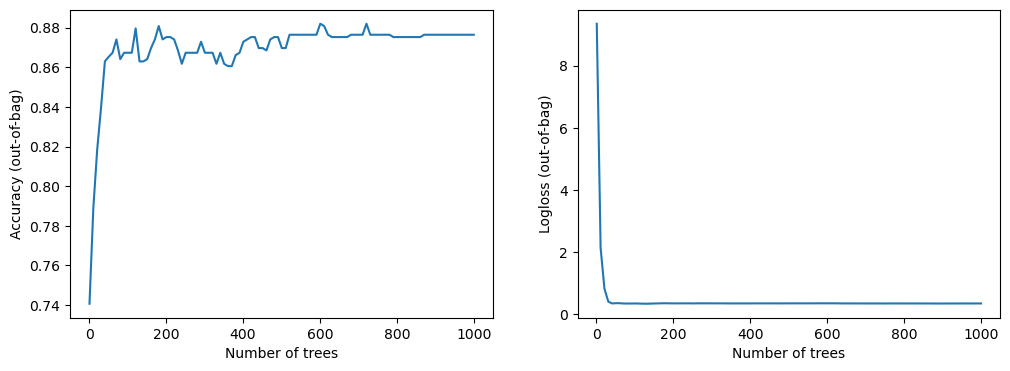


Train: 0.1731 Validation: 0.3276
##### Fold 2
Use /tmp/tmp66pud77s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.694928. Found 514 examples.
Training model...
Model trained in 0:00:01.082228
Compiling model...


[INFO 23-07-29 20:16:00.9820 UTC kernel.cc:1242] Loading model from path /tmp/tmp66pud77s/model/ with prefix ada11532a28948aa
[INFO 23-07-29 20:16:01.0986 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33396 node(s), and 113 input feature(s).
[INFO 23-07-29 20:16:01.0987 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:16:01.0987 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 351ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9515 - balanced_log_loss: 0.2998


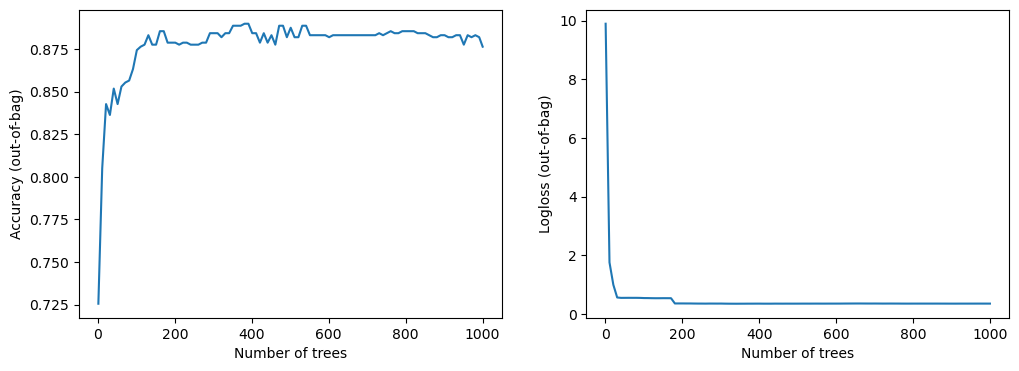


Train: 0.5067 Validation: 0.2998
##### Fold 3
Use /tmp/tmpef0l2dly as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.700630. Found 514 examples.
Training model...
Model trained in 0:00:01.088711
Compiling model...


[INFO 23-07-29 20:16:07.2702 UTC kernel.cc:1242] Loading model from path /tmp/tmpef0l2dly/model/ with prefix 7ec97384cc224f50
[INFO 23-07-29 20:16:07.3860 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33376 node(s), and 113 input feature(s).
[INFO 23-07-29 20:16:07.3860 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 518ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3269


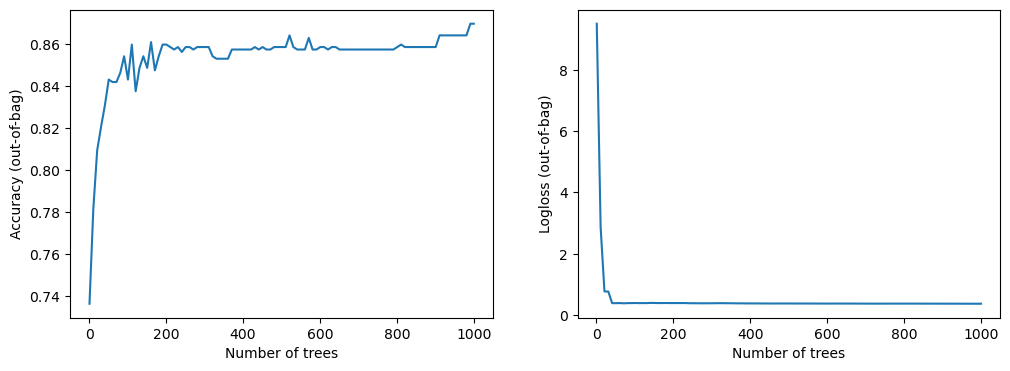


Train: 0.4829 Validation: 0.3269
##### Fold 4
Use /tmp/tmpl6gl8qe1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.117820. Found 514 examples.
Training model...
Model trained in 0:00:01.085656
Compiling model...


[INFO 23-07-29 20:16:14.3457 UTC kernel.cc:1242] Loading model from path /tmp/tmpl6gl8qe1/model/ with prefix 12a0a2ad9b44478b
[INFO 23-07-29 20:16:14.4602 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33208 node(s), and 113 input feature(s).
[INFO 23-07-29 20:16:14.4603 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:16:14.4604 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 339ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3500


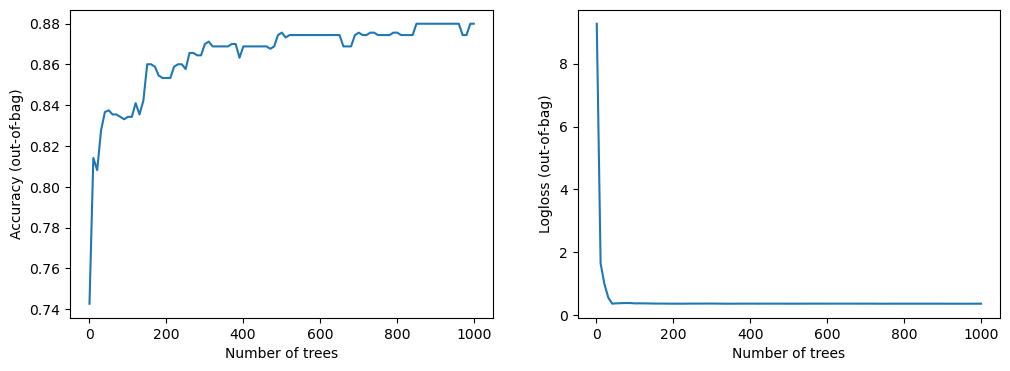


Train: 0.5023 Validation: 0.3500
##### Fold 5
Use /tmp/tmpyri2zs3a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.729290. Found 514 examples.
Training model...
Model trained in 0:00:01.089598
Compiling model...


[INFO 23-07-29 20:16:20.9666 UTC kernel.cc:1242] Loading model from path /tmp/tmpyri2zs3a/model/ with prefix 50d61acf965d4f33
[INFO 23-07-29 20:16:21.0843 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33428 node(s), and 113 input feature(s).
[INFO 23-07-29 20:16:21.0843 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 337ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3811


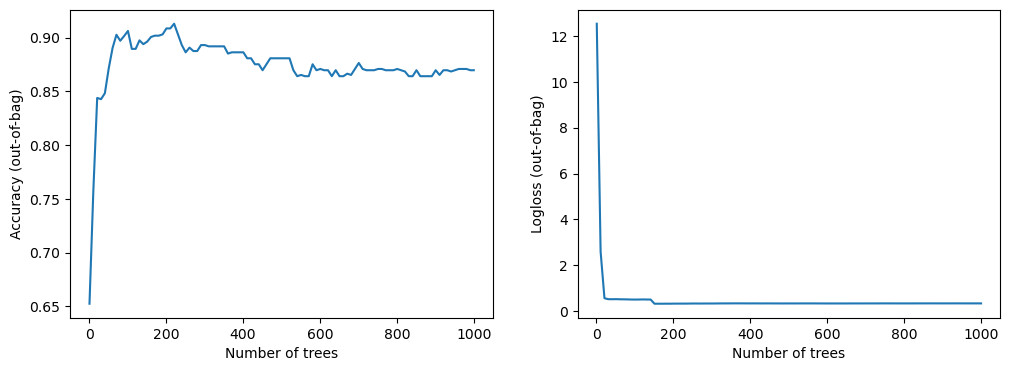


Train: 0.5224 Validation: 0.3811
##### Fold 6
Use /tmp/tmpsq_sb8sj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.702169. Found 515 examples.
Training model...
Model trained in 0:00:01.080337
Compiling model...


[INFO 23-07-29 20:16:27.2210 UTC kernel.cc:1242] Loading model from path /tmp/tmpsq_sb8sj/model/ with prefix 4ff14d5baa114ea6
[INFO 23-07-29 20:16:27.3385 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33260 node(s), and 114 input feature(s).
[INFO 23-07-29 20:16:27.3386 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:16:27.3387 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 353ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9020 - balanced_log_loss: 0.4208


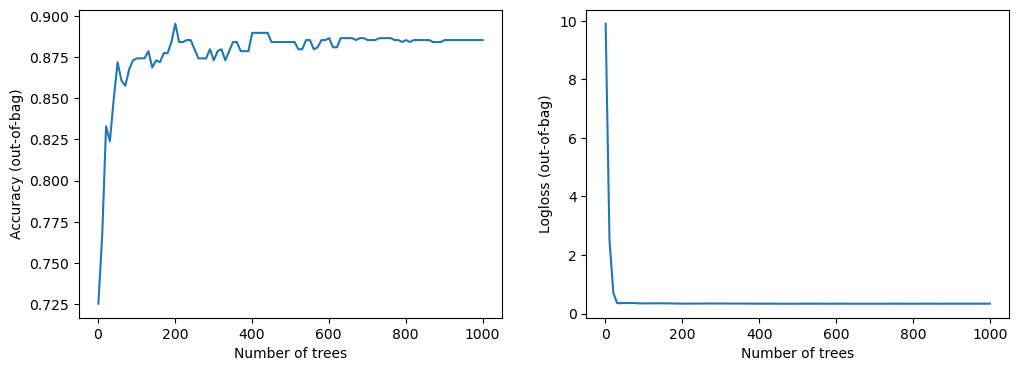


Train: 0.5493 Validation: 0.4208

Train mean: 0.4561 std: 0.1404

Validation mean: 0.3510 std: 0.0437
1/1 [==============================] - 0s 210ms/step


In [11]:
# RandomForestModel

# Test
my_splitter = StratifiedKFold(n_splits=6,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_1 = CV_Ensemble_1.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_1.save(save_path='/kaggle/working/RF/1')

# train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 

train_summary_rf_1 = CV_Ensemble_1.X_summary
valid_summary_rf_1 = CV_Ensemble_1.valid_summary
test_summary_rf_1 = CV_Ensemble_1.predict(X=test_out)
model_rf_1 = CV_Ensemble_1.models
metrics_rf_1 = CV_Ensemble_1.metrics

##### Fold 1
Use /tmp/tmpp2zbyer_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.778071. Found 555 examples.
Training model...
Model trained in 0:00:00.370405
Compiling model...


[INFO 23-07-29 20:17:02.4690 UTC kernel.cc:1242] Loading model from path /tmp/tmpp2zbyer_/model/ with prefix dfc2c49510fc461f
[INFO 23-07-29 20:17:02.5079 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10268 node(s), and 112 input feature(s).
[INFO 23-07-29 20:17:02.5079 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:17:02.5081 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 334ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3026


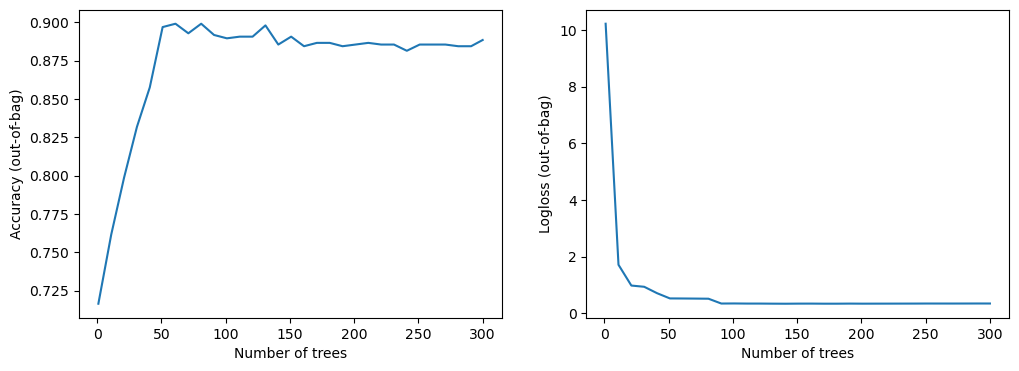


Train: 0.1776 Validation: 0.3026
##### Fold 2
Use /tmp/tmpyamtw30a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.702914. Found 555 examples.
Training model...
Model trained in 0:00:00.359628
Compiling model...


[INFO 23-07-29 20:17:08.8591 UTC kernel.cc:1242] Loading model from path /tmp/tmpyamtw30a/model/ with prefix 224f6ae8473147e3
[INFO 23-07-29 20:17:08.8953 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10250 node(s), and 110 input feature(s).
[INFO 23-07-29 20:17:08.8953 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 382ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3518


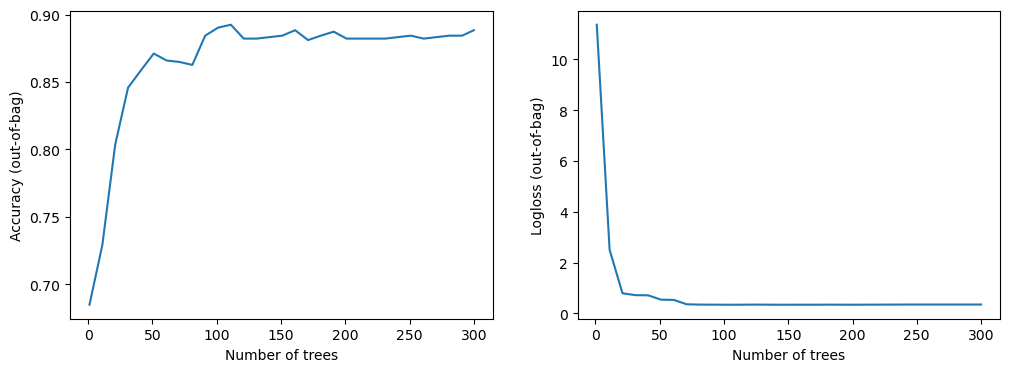


Train: 0.4775 Validation: 0.3518
##### Fold 3
Use /tmp/tmp4yms9oee as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.251769. Found 555 examples.
Training model...
Model trained in 0:00:00.363325
Compiling model...


[INFO 23-07-29 20:17:15.4640 UTC kernel.cc:1242] Loading model from path /tmp/tmp4yms9oee/model/ with prefix 5a319057974a4946
[INFO 23-07-29 20:17:15.5006 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10302 node(s), and 113 input feature(s).
[INFO 23-07-29 20:17:15.5007 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:17:15.5008 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 334ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_log_loss: 0.2532


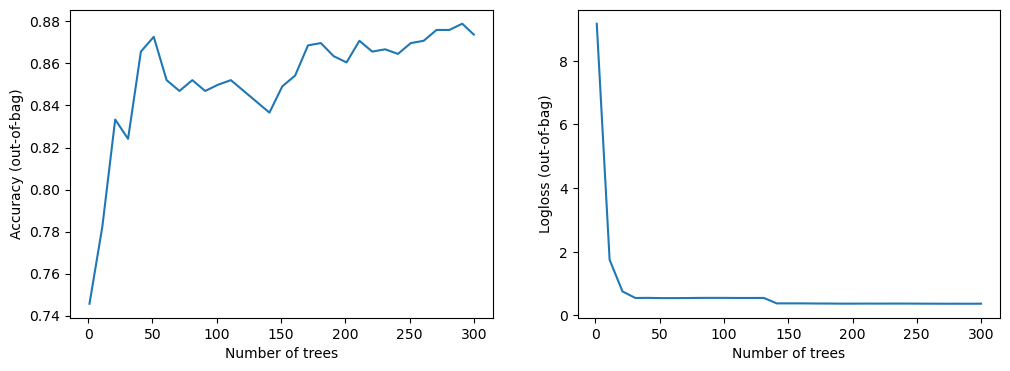


Train: 0.5394 Validation: 0.2532
##### Fold 4
Use /tmp/tmp513s6w0q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.767084. Found 555 examples.
Training model...
Model trained in 0:00:00.373004
Compiling model...


[INFO 23-07-29 20:17:21.9350 UTC kernel.cc:1242] Loading model from path /tmp/tmp513s6w0q/model/ with prefix 8f8af7e2cb9e4fa9
[INFO 23-07-29 20:17:21.9724 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10350 node(s), and 112 input feature(s).
[INFO 23-07-29 20:17:21.9726 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 334ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3232


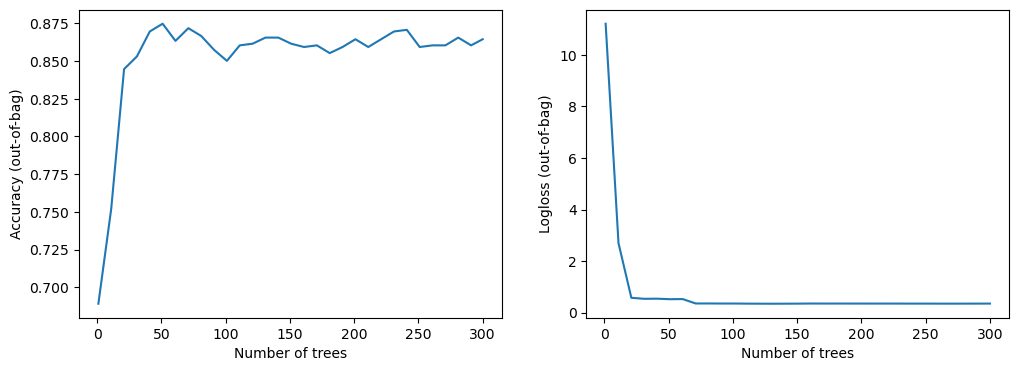


Train: 0.4308 Validation: 0.3232
##### Fold 5
Use /tmp/tmp1xtoo5ea as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.709209. Found 555 examples.
Training model...
Model trained in 0:00:00.358413
Compiling model...


[INFO 23-07-29 20:17:28.3153 UTC kernel.cc:1242] Loading model from path /tmp/tmp1xtoo5ea/model/ with prefix b3713ec6f71d46b5
[INFO 23-07-29 20:17:28.3518 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10290 node(s), and 112 input feature(s).
[INFO 23-07-29 20:17:28.3519 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:17:28.3519 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 339ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3334


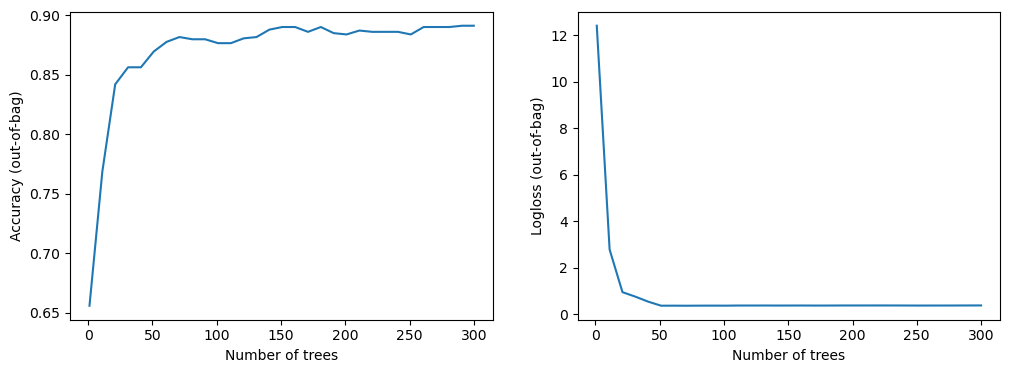


Train: 0.5062 Validation: 0.3334
##### Fold 6
Use /tmp/tmpojnbko_v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.760027. Found 555 examples.
Training model...
Model trained in 0:00:00.365365
Compiling model...


[INFO 23-07-29 20:17:33.7520 UTC kernel.cc:1242] Loading model from path /tmp/tmpojnbko_v/model/ with prefix 325768ec179443c9
[INFO 23-07-29 20:17:33.7893 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10464 node(s), and 113 input feature(s).
[INFO 23-07-29 20:17:33.7893 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 330ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.4007


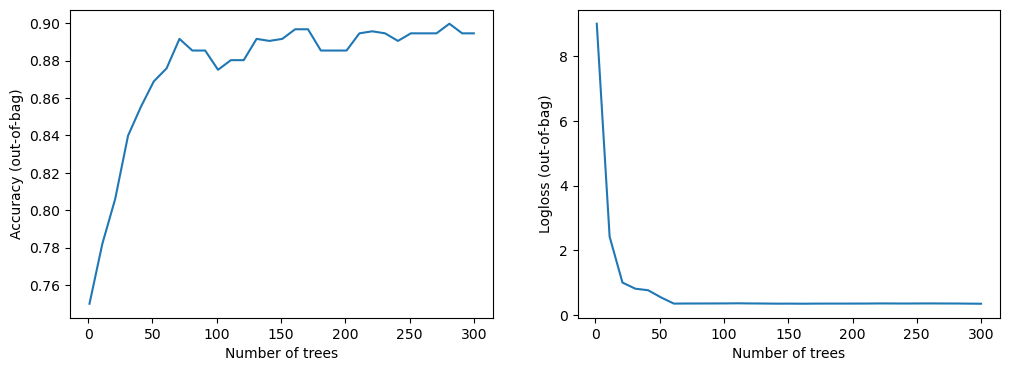


Train: 0.5031 Validation: 0.4007
##### Fold 7
Use /tmp/tmpjitaqpx8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.713882. Found 555 examples.
Training model...
Model trained in 0:00:00.356790
Compiling model...


[INFO 23-07-29 20:17:38.9813 UTC kernel.cc:1242] Loading model from path /tmp/tmpjitaqpx8/model/ with prefix 11a93d43495d43d1
[INFO 23-07-29 20:17:39.0159 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10096 node(s), and 113 input feature(s).
[INFO 23-07-29 20:17:39.0159 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:17:39.0160 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 351ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3264


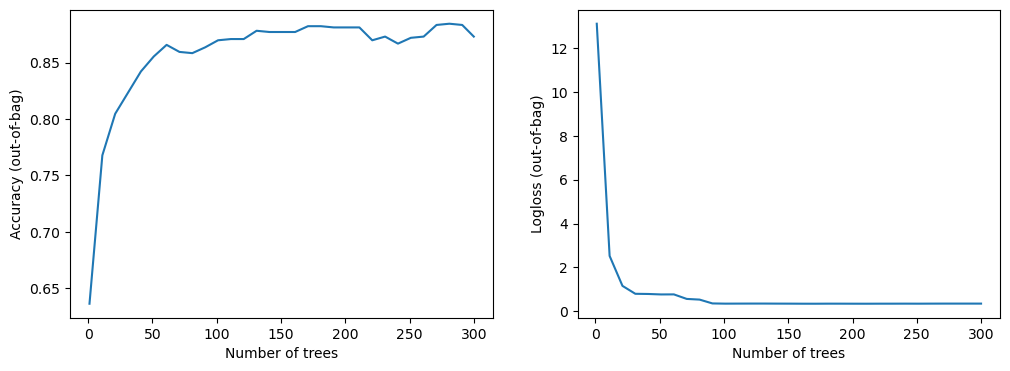


Train: 0.5776 Validation: 0.3264
##### Fold 8
Use /tmp/tmp50vpcdc1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.835725. Found 556 examples.
Training model...
Model trained in 0:00:00.633311
Compiling model...


[INFO 23-07-29 20:17:45.9284 UTC kernel.cc:1242] Loading model from path /tmp/tmp50vpcdc1/model/ with prefix 8a1ea4ddb9f842f5
[INFO 23-07-29 20:17:45.9813 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10276 node(s), and 113 input feature(s).
[INFO 23-07-29 20:17:45.9818 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 332ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.3201


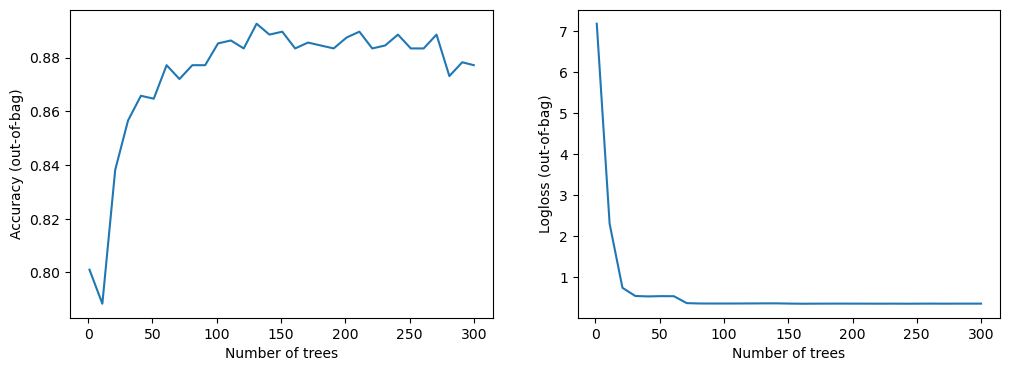


Train: 0.5045 Validation: 0.3201
##### Fold 9
Use /tmp/tmp9kt87e78 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.731594. Found 556 examples.
Training model...
Model trained in 0:00:00.385617
Compiling model...


[INFO 23-07-29 20:17:51.8684 UTC kernel.cc:1242] Loading model from path /tmp/tmp9kt87e78/model/ with prefix c8dc7e7cec99466c
[INFO 23-07-29 20:17:51.9044 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10168 node(s), and 112 input feature(s).
[INFO 23-07-29 20:17:51.9045 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:17:51.9046 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 334ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4664


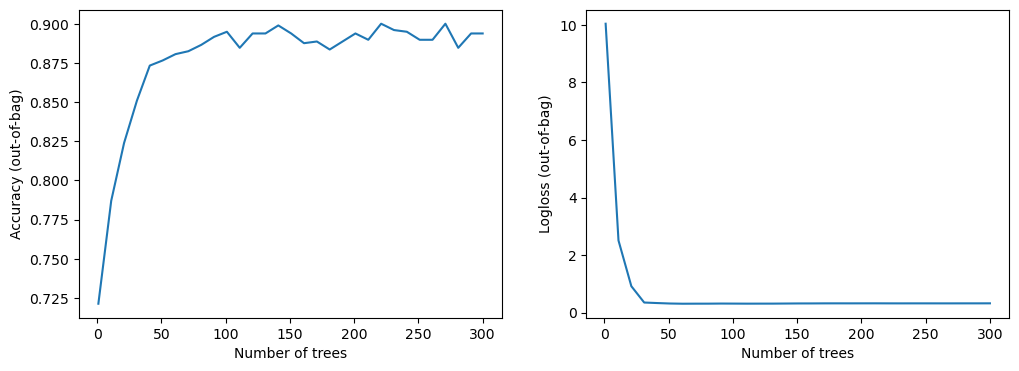


Train: 0.4883 Validation: 0.4664
##### Fold 10
Use /tmp/tmpvs8rbyn5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.714264. Found 556 examples.
Training model...
Model trained in 0:00:00.366667
Compiling model...


[INFO 23-07-29 20:17:58.2533 UTC kernel.cc:1242] Loading model from path /tmp/tmpvs8rbyn5/model/ with prefix 92a5a1b969b44625
[INFO 23-07-29 20:17:58.2899 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10406 node(s), and 111 input feature(s).
[INFO 23-07-29 20:17:58.2900 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 337ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.3531


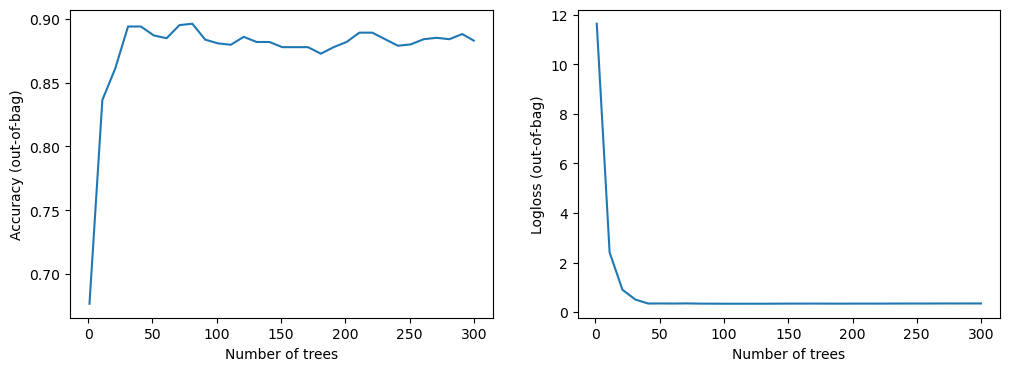


Train: 0.6396 Validation: 0.3531

Train mean: 0.4845 std: 0.1221

Validation mean: 0.3431 std: 0.0574
1/1 [==============================] - 0s 334ms/step


In [12]:
# RandomForestModel

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_2 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_2 = CV_Ensemble_2.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=300),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_2.save(save_path='/kaggle/working/RF/2')

# Collect attributes and predictions

train_summary_rf_2 = CV_Ensemble_2.X_summary
valid_summary_rf_2 = CV_Ensemble_2.valid_summary
test_summary_rf_2 = CV_Ensemble_2.predict(X=test_out)
model_rf_2 = CV_Ensemble_2.models
metrics_rf_2 = CV_Ensemble_2.metrics


##### Fold 1
Use /tmp/tmpf_3xrmnw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.015970. Found 555 examples.
Training model...
Model trained in 0:00:00.295631
Compiling model...


[INFO 23-07-29 20:18:51.5864 UTC kernel.cc:1242] Loading model from path /tmp/tmpf_3xrmnw/model/ with prefix f858405efce04ce2
[INFO 23-07-29 20:18:51.6258 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11260 node(s), and 59 input feature(s).
[INFO 23-07-29 20:18:51.6259 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:18:51.6260 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 233ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3091


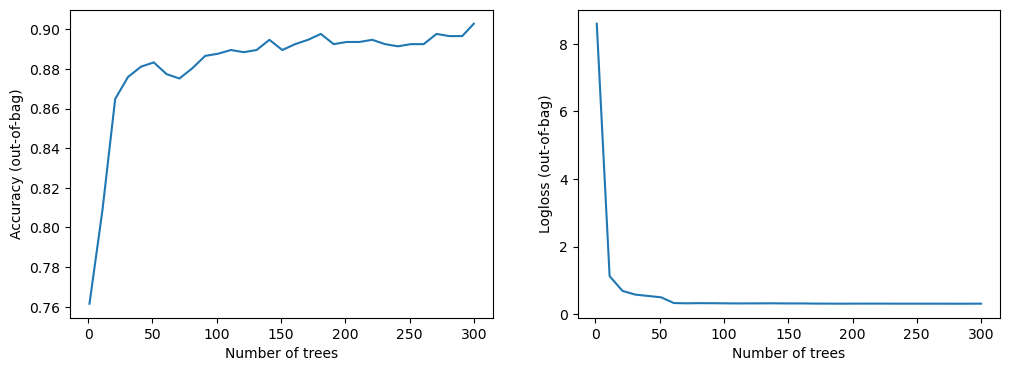


Train: 0.1883 Validation: 0.3091
##### Fold 2
Use /tmp/tmp1758gidj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.015534. Found 555 examples.
Training model...
Model trained in 0:00:00.240777
Compiling model...


[INFO 23-07-29 20:18:54.9835 UTC kernel.cc:1242] Loading model from path /tmp/tmp1758gidj/model/ with prefix ed8cf9de0d92460a
[INFO 23-07-29 20:18:55.0224 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-29 20:18:55.0225 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 237ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3418


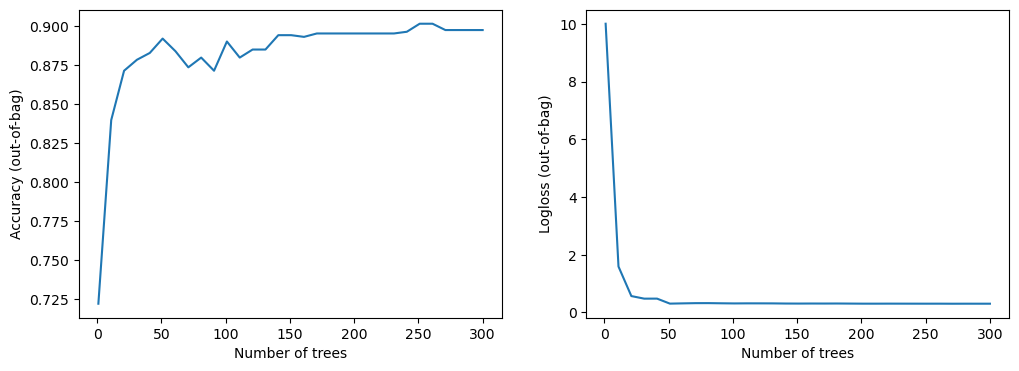


Train: 0.4968 Validation: 0.3418
##### Fold 3
Use /tmp/tmpwcx77qap as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.926453. Found 555 examples.
Training model...
Model trained in 0:00:00.250900
Compiling model...


[INFO 23-07-29 20:18:59.3028 UTC kernel.cc:1242] Loading model from path /tmp/tmpwcx77qap/model/ with prefix 526f0475b3f34ea8
[INFO 23-07-29 20:18:59.3455 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-29 20:18:59.3456 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 243ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_log_loss: 0.2186


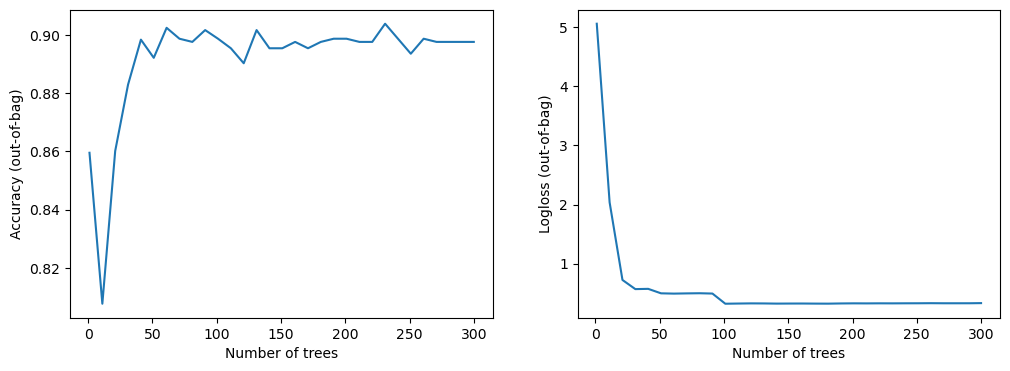


Train: 0.5382 Validation: 0.2186
##### Fold 4
Use /tmp/tmp84b6onct as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.062480. Found 555 examples.
Training model...
Model trained in 0:00:00.251099
Compiling model...


[INFO 23-07-29 20:19:02.8529 UTC kernel.cc:1242] Loading model from path /tmp/tmp84b6onct/model/ with prefix ee221797bf104011
[INFO 23-07-29 20:19:02.8929 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11274 node(s), and 58 input feature(s).
[INFO 23-07-29 20:19:02.8930 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:19:02.8931 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 244ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2880


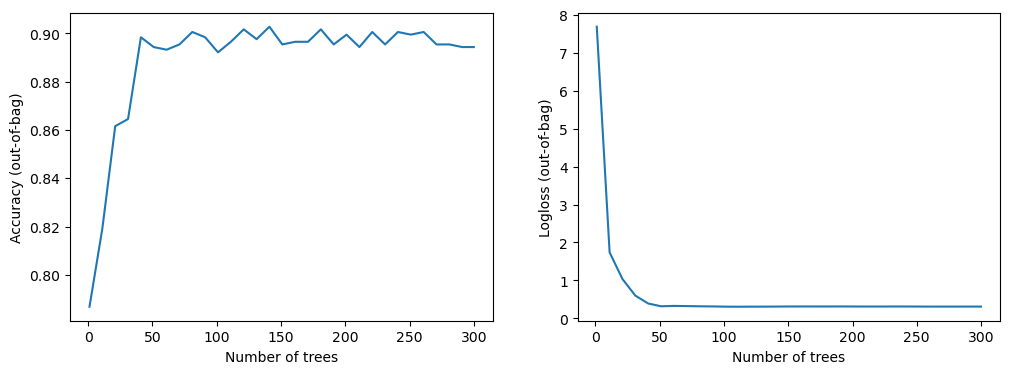


Train: 0.4091 Validation: 0.2880
##### Fold 5
Use /tmp/tmp7n5xw6_s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.999859. Found 555 examples.
Training model...
Model trained in 0:00:00.239121
Compiling model...


[INFO 23-07-29 20:19:06.3243 UTC kernel.cc:1242] Loading model from path /tmp/tmp7n5xw6_s/model/ with prefix 7274a94245e54337
[INFO 23-07-29 20:19:06.3639 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11210 node(s), and 58 input feature(s).
[INFO 23-07-29 20:19:06.3640 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 236ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2901


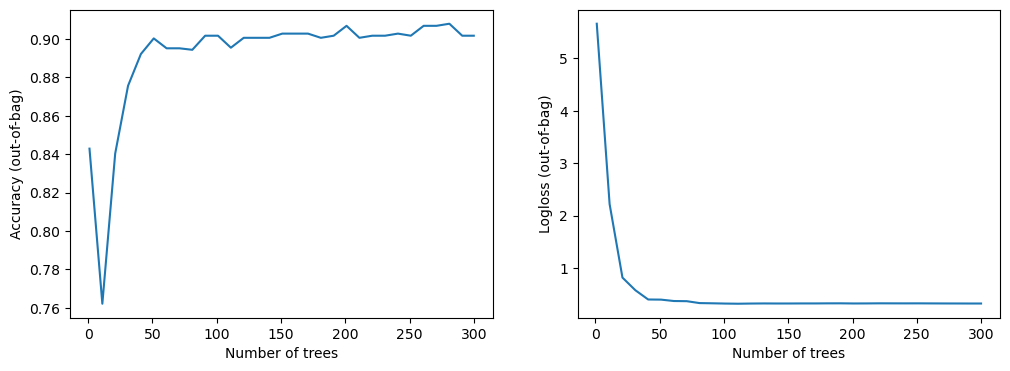


Train: 0.4847 Validation: 0.2901
##### Fold 6
Use /tmp/tmp4_iy8_i0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.009774. Found 555 examples.
Training model...
Model trained in 0:00:00.246580
Compiling model...


[INFO 23-07-29 20:19:09.7342 UTC kernel.cc:1242] Loading model from path /tmp/tmp4_iy8_i0/model/ with prefix b03773b20b214485
[INFO 23-07-29 20:19:09.7735 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11268 node(s), and 58 input feature(s).
[INFO 23-07-29 20:19:09.7736 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 244ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3444


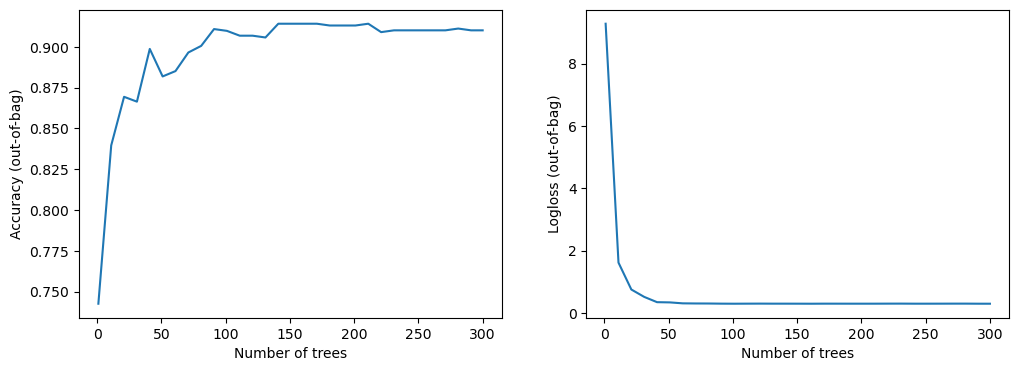


Train: 0.4697 Validation: 0.3444
##### Fold 7
Use /tmp/tmpglum8myp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.007049. Found 555 examples.
Training model...
Model trained in 0:00:00.241954
Compiling model...


[INFO 23-07-29 20:19:13.1560 UTC kernel.cc:1242] Loading model from path /tmp/tmpglum8myp/model/ with prefix f7401b6aeada4564
[INFO 23-07-29 20:19:13.1948 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11172 node(s), and 58 input feature(s).
[INFO 23-07-29 20:19:13.1948 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:19:13.1949 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 234ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2836


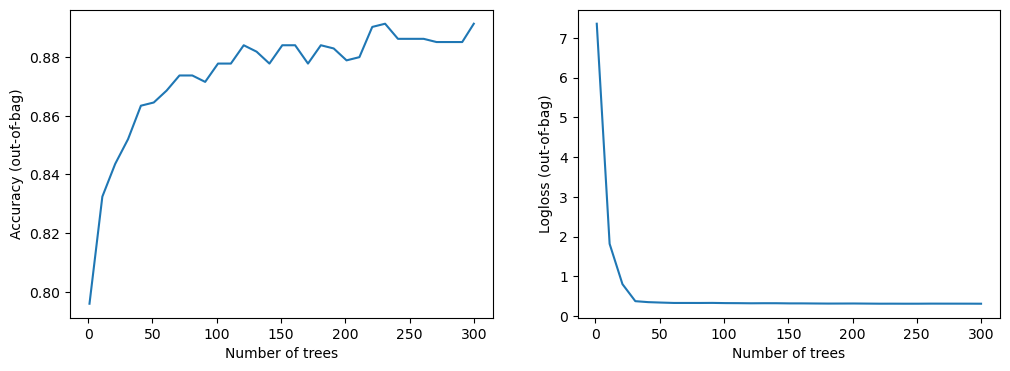


Train: 0.5343 Validation: 0.2836
##### Fold 8
Use /tmp/tmpw9td1ra2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.999810. Found 556 examples.
Training model...
Model trained in 0:00:00.237160
Compiling model...


[INFO 23-07-29 20:19:16.5259 UTC kernel.cc:1242] Loading model from path /tmp/tmpw9td1ra2/model/ with prefix c495db07f7ca4cfb
[INFO 23-07-29 20:19:16.5637 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11026 node(s), and 58 input feature(s).
[INFO 23-07-29 20:19:16.5638 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 232ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.2572


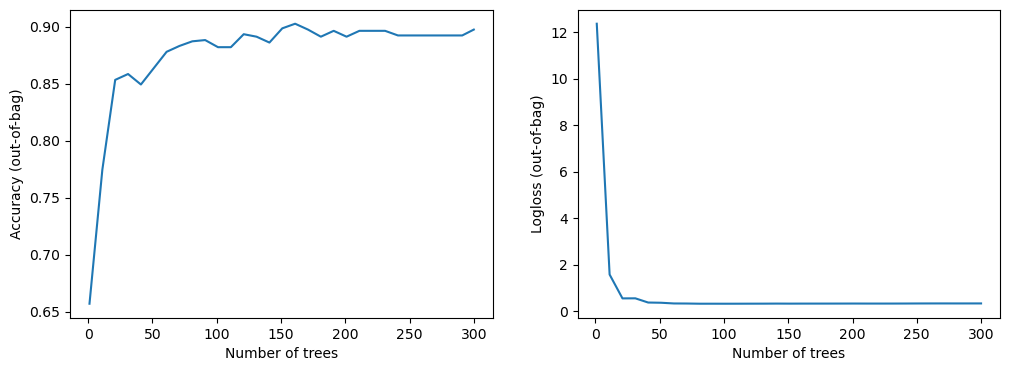


Train: 0.4778 Validation: 0.2572
##### Fold 9
Use /tmp/tmporo5zc1e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.019824. Found 556 examples.
Training model...
Model trained in 0:00:00.284927
Compiling model...


[INFO 23-07-29 20:19:20.4157 UTC kernel.cc:1242] Loading model from path /tmp/tmporo5zc1e/model/ with prefix e2356d9139d14029
[INFO 23-07-29 20:19:20.4545 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11098 node(s), and 58 input feature(s).
[INFO 23-07-29 20:19:20.4546 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 238ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4250


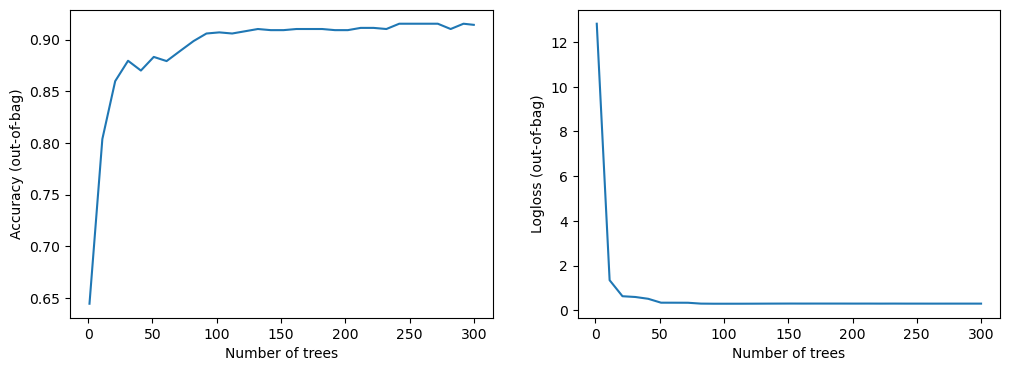


Train: 0.4395 Validation: 0.4250
##### Fold 10
Use /tmp/tmpsudsg1qp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.011488. Found 556 examples.
Training model...
Model trained in 0:00:00.241386
Compiling model...


[INFO 23-07-29 20:19:24.4739 UTC kernel.cc:1242] Loading model from path /tmp/tmpsudsg1qp/model/ with prefix 0e32962da4f744c2
[INFO 23-07-29 20:19:24.5144 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11344 node(s), and 58 input feature(s).
[INFO 23-07-29 20:19:24.5144 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 20:19:24.5145 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 235ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3016


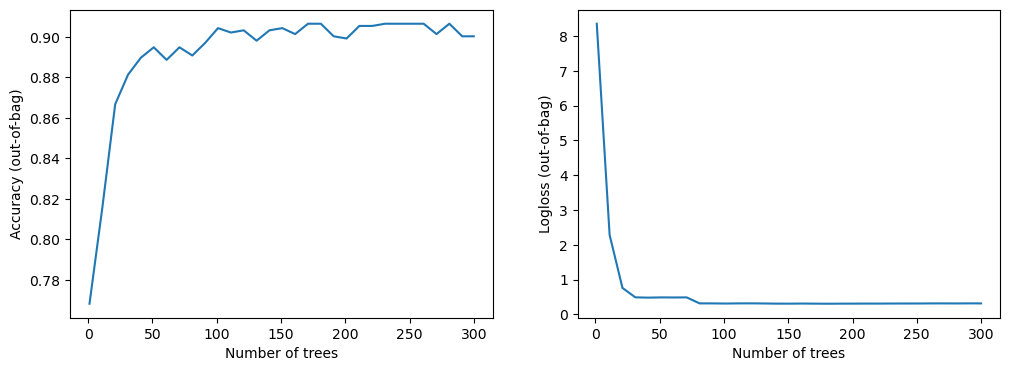


Train: 0.6154 Validation: 0.3016

Train mean: 0.4654 std: 0.1129

Validation mean: 0.3059 std: 0.0558
1/1 [==============================] - 0s 123ms/step


In [13]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_3 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_3 = CV_Ensemble_3.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=300),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_3.save(save_path='/kaggle/working/RF/3')

# Collect attributes and predictions

train_summary_rf_3 = CV_Ensemble_3.X_summary
valid_summary_rf_3 = CV_Ensemble_3.valid_summary
test_summary_rf_3 = CV_Ensemble_3.predict(X=test_out)
model_rf_3 = CV_Ensemble_3.models
metrics_rf_3 = CV_Ensemble_3.metrics

# GradientBoostedTreesModel

##### Fold 1
Use /tmp/tmp399ggch7 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:19:55.7888 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:19:55.7889 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:19:55.7889 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.019357. Found 555 examples.
Training model...
Model trained in 0:00:00.850756
Compiling model...


[INFO 23-07-29 20:19:57.6614 UTC kernel.cc:1242] Loading model from path /tmp/tmp399ggch7/model/ with prefix 3f67d8e6b3ef4304
[INFO 23-07-29 20:19:57.6667 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:19:57.6667 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 236ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2432


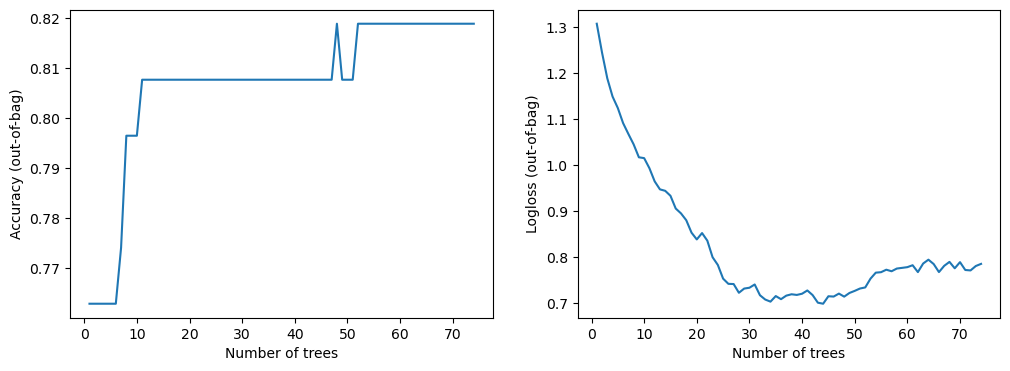


Train: 0.0893 Validation: 0.2432
##### Fold 2
Use /tmp/tmpdi6jf3ds as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:20:00.8997 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:00.8997 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:00.8997 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.098599. Found 555 examples.
Training model...
Model trained in 0:00:00.832357
Compiling model...


[INFO 23-07-29 20:20:02.8351 UTC kernel.cc:1242] Loading model from path /tmp/tmpdi6jf3ds/model/ with prefix b86e0684f01c4519
[INFO 23-07-29 20:20:02.8400 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 231ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2464


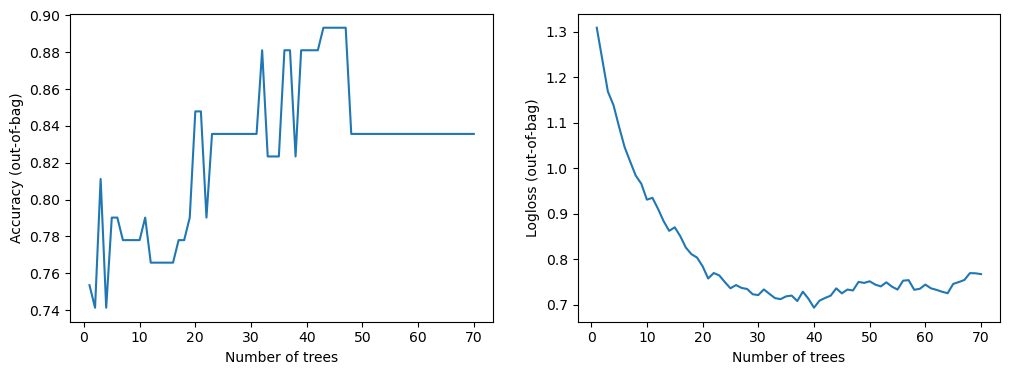


Train: 0.3326 Validation: 0.2464
##### Fold 3
Use /tmp/tmpo6munqsv as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:20:06.0958 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:06.0958 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:06.0959 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.025660. Found 555 examples.
Training model...
Model trained in 0:00:01.002383
Compiling model...


[INFO 23-07-29 20:20:08.1250 UTC kernel.cc:1242] Loading model from path /tmp/tmpo6munqsv/model/ with prefix c67b832c5a824fa0
[INFO 23-07-29 20:20:08.1316 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:20:08.1316 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 234ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1154


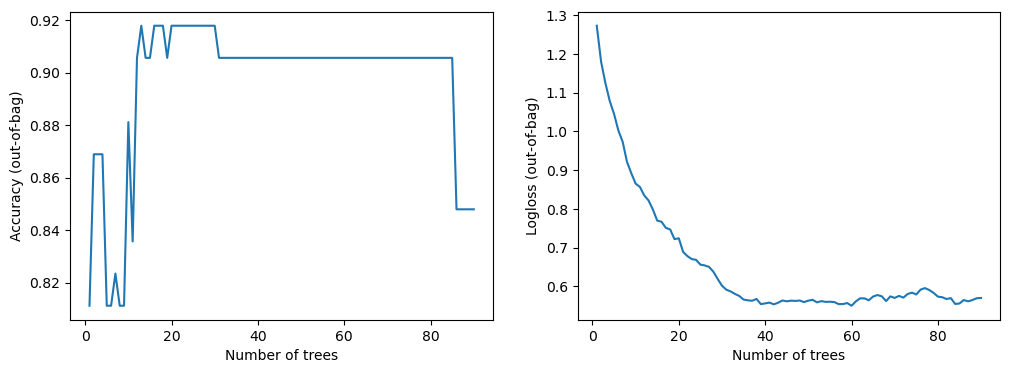


Train: 0.3043 Validation: 0.1154
##### Fold 4
Use /tmp/tmpclsybf4n as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:20:11.1768 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:11.1768 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:11.1768 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.071894. Found 555 examples.
Training model...
Model trained in 0:00:00.728477
Compiling model...


[INFO 23-07-29 20:20:12.9814 UTC kernel.cc:1242] Loading model from path /tmp/tmpclsybf4n/model/ with prefix 76c4cf5d03fb44ee
[INFO 23-07-29 20:20:12.9856 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 237ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2950


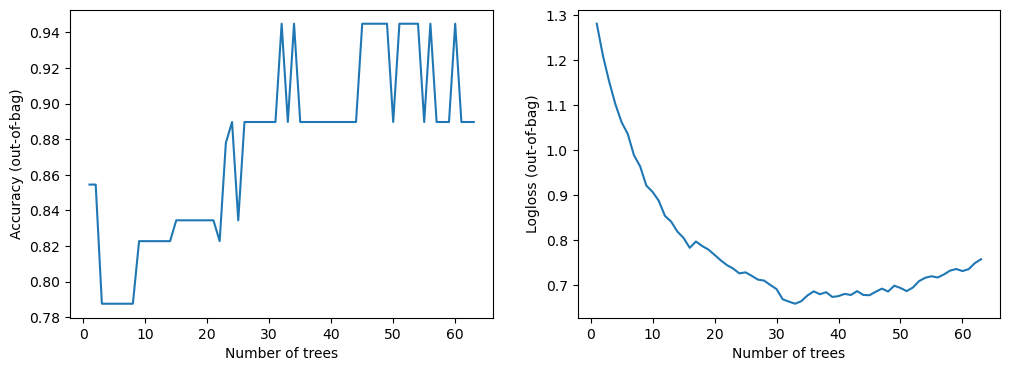


Train: 0.2279 Validation: 0.2950
##### Fold 5
Use /tmp/tmpjhvgftjz as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:20:16.3851 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:16.3852 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:16.3854 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.031400. Found 555 examples.
Training model...
Model trained in 0:00:01.149476
Compiling model...


[INFO 23-07-29 20:20:18.5659 UTC kernel.cc:1242] Loading model from path /tmp/tmpjhvgftjz/model/ with prefix 0551ec8a7efb4079
[INFO 23-07-29 20:20:18.5740 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:20:18.5741 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 247ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2456


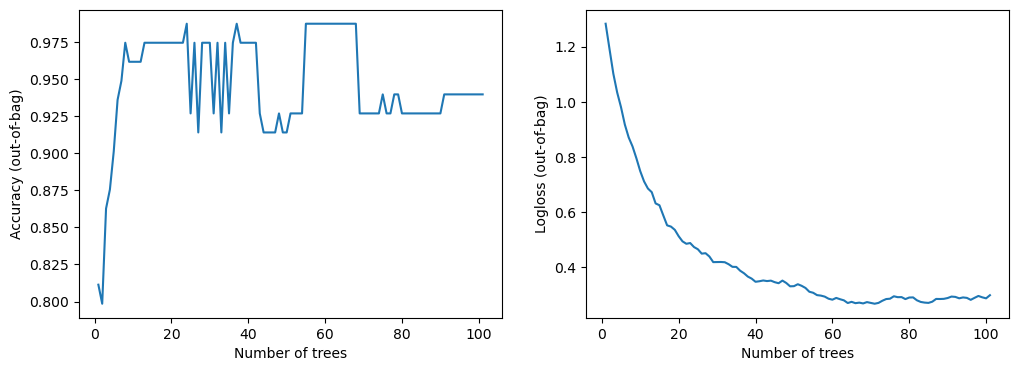


Train: 0.3301 Validation: 0.2456
##### Fold 6
Use /tmp/tmpaxz_w0hm as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:20:20.7202 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:20.7202 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:20.7203 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.088674. Found 555 examples.
Training model...
Model trained in 0:00:01.017987
Compiling model...


[INFO 23-07-29 20:20:22.8284 UTC kernel.cc:1242] Loading model from path /tmp/tmpaxz_w0hm/model/ with prefix a4c0683b235b4845
[INFO 23-07-29 20:20:22.8352 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 371ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3147


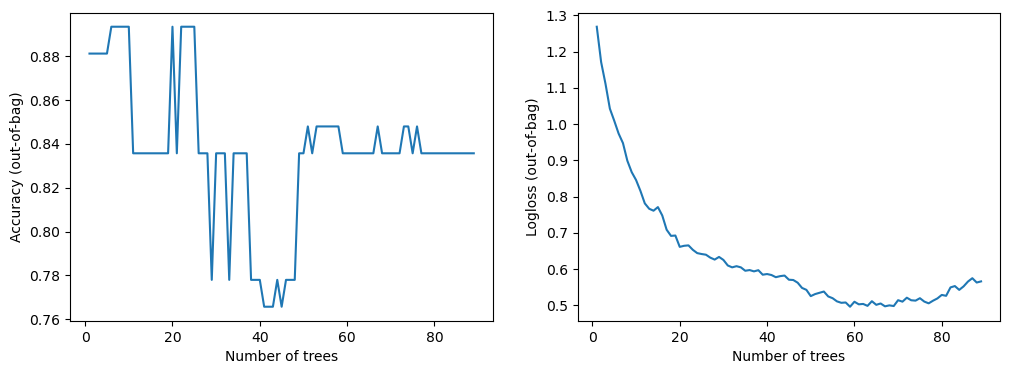


Train: 0.2965 Validation: 0.3147
##### Fold 7
Use /tmp/tmpzau_u6or as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:20:26.4730 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:26.4731 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:26.4732 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.019364. Found 555 examples.
Training model...
Model trained in 0:00:01.226339
Compiling model...


[INFO 23-07-29 20:20:28.7178 UTC kernel.cc:1242] Loading model from path /tmp/tmpzau_u6or/model/ with prefix 0f13a1604c5c45f2
[INFO 23-07-29 20:20:28.7259 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:20:28.7260 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 241ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3183


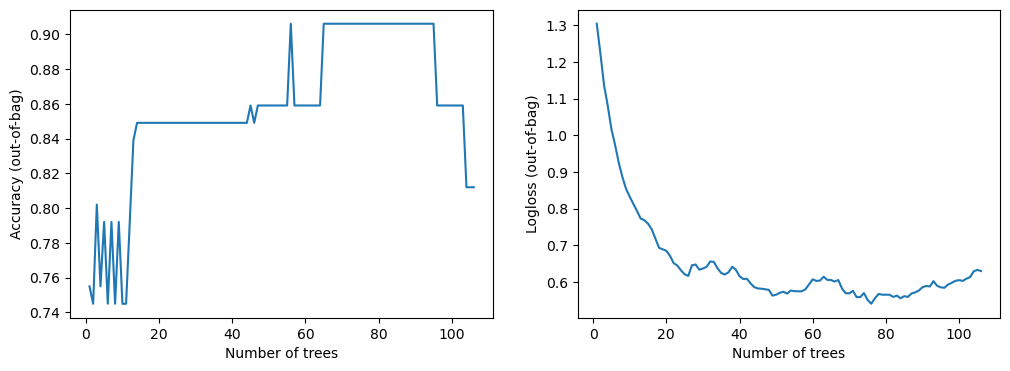


Train: 0.3593 Validation: 0.3183
##### Fold 8
Use /tmp/tmpe8knc7qt as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:20:31.7832 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:31.7832 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:31.7832 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.137520. Found 556 examples.
Training model...
Model trained in 0:00:01.267225
Compiling model...


[INFO 23-07-29 20:20:34.1863 UTC kernel.cc:1242] Loading model from path /tmp/tmpe8knc7qt/model/ with prefix 8b4988833c464ec0
[INFO 23-07-29 20:20:34.1957 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 240ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.1722


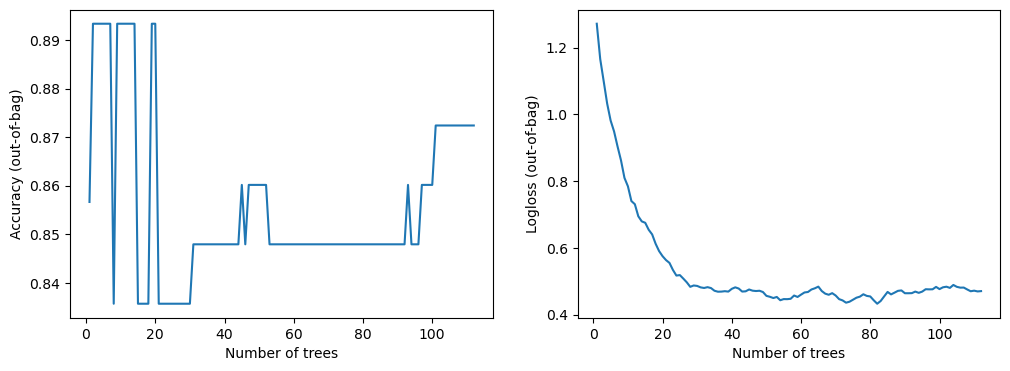


Train: 0.3549 Validation: 0.1722
##### Fold 9
Use /tmp/tmp2jctpcn5 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:20:36.3375 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:36.3376 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:36.3376 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.031731. Found 556 examples.
Training model...
Model trained in 0:00:02.287054
Compiling model...


[INFO 23-07-29 20:20:39.6466 UTC kernel.cc:1242] Loading model from path /tmp/tmp2jctpcn5/model/ with prefix f0fc2c03880e4a09
[INFO 23-07-29 20:20:39.6641 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:20:39.6641 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 236ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.9113


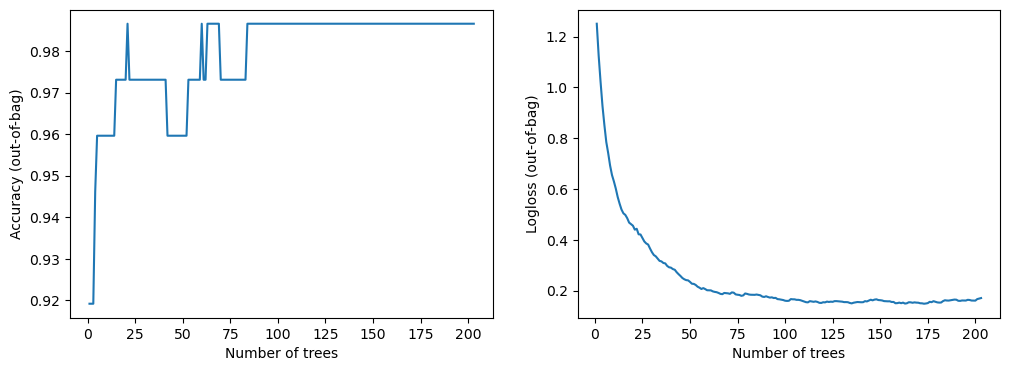


Train: 0.1788 Validation: 0.9113
##### Fold 10
Use /tmp/tmpqvn3n995 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:20:41.8292 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:41.8293 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:20:41.8293 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.017686. Found 556 examples.
Training model...
Model trained in 0:00:01.454312
Compiling model...


[INFO 23-07-29 20:20:44.2983 UTC kernel.cc:1242] Loading model from path /tmp/tmpqvn3n995/model/ with prefix fdf66841d3e94dcf
[INFO 23-07-29 20:20:44.3088 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 236ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.1701


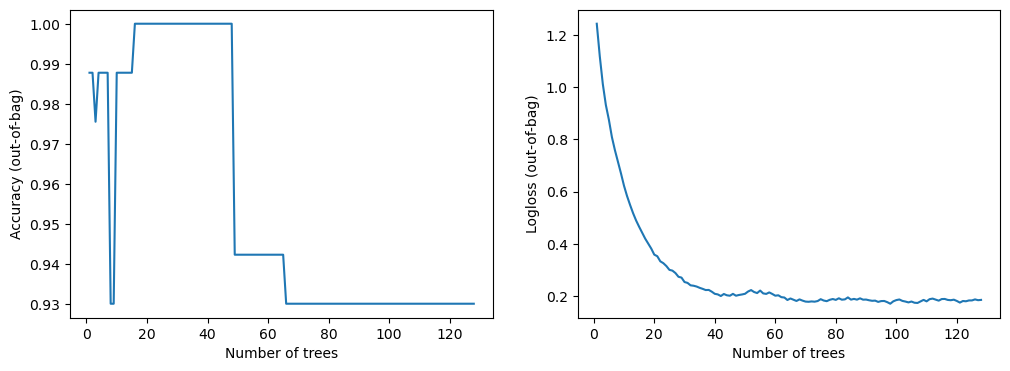


Train: 0.9280 Validation: 0.1701

Train mean: 0.3402 std: 0.2239

Validation mean: 0.3032 std: 0.2237
1/1 [==============================] - 0s 128ms/step


In [14]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_GBT_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.GradientBoostedTreesModel, label="Class")

# train
CV_Ensemble_GBT_1 = CV_Ensemble_GBT_1.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=5, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_GBT_1.save(save_path='/kaggle/working/GBT/1')

# Collect attributes and predictions

train_summary_gbt_1 = CV_Ensemble_GBT_1.X_summary
valid_summary_gbt_1 = CV_Ensemble_GBT_1.valid_summary
test_summary_gbt_1 = CV_Ensemble_GBT_1.predict(X=test_out)
model_gbt_1 = CV_Ensemble_GBT_1.models
metrics_gbt_1 = CV_Ensemble_GBT_1.metrics

##### Fold 1
Use /tmp/tmpyt38i9q4 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:21:15.0741 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:15.0742 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:15.0742 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.056686. Found 555 examples.
Training model...
Model trained in 0:00:01.145803
Compiling model...


[INFO 23-07-29 20:21:17.2742 UTC kernel.cc:1242] Loading model from path /tmp/tmpyt38i9q4/model/ with prefix e2aaf94965a04159
[INFO 23-07-29 20:21:17.2841 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:21:17.2842 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 231ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.2472


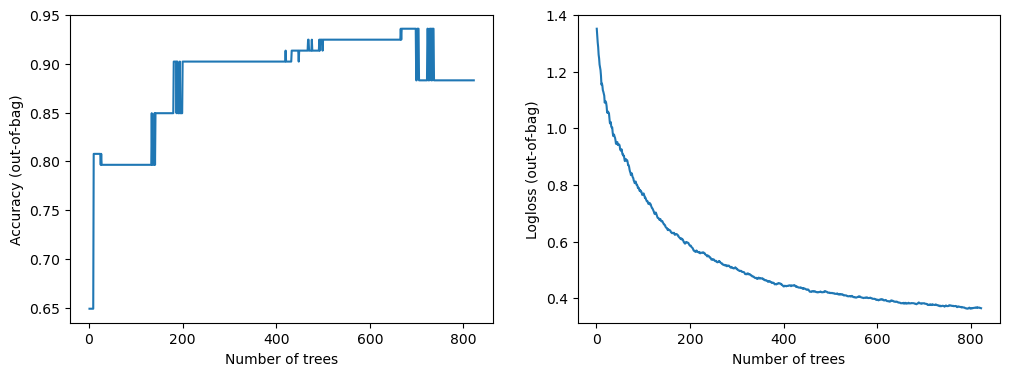


Train: 0.1104 Validation: 0.2472
##### Fold 2
Use /tmp/tmpkasyrk9d as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:21:20.1913 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:20.1915 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:20.1916 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.039153. Found 555 examples.
Training model...
Model trained in 0:00:00.813552
Compiling model...


[INFO 23-07-29 20:21:22.0464 UTC kernel.cc:1242] Loading model from path /tmp/tmpkasyrk9d/model/ with prefix b1aeb1b9c53543ac
[INFO 23-07-29 20:21:22.0531 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 233ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3298


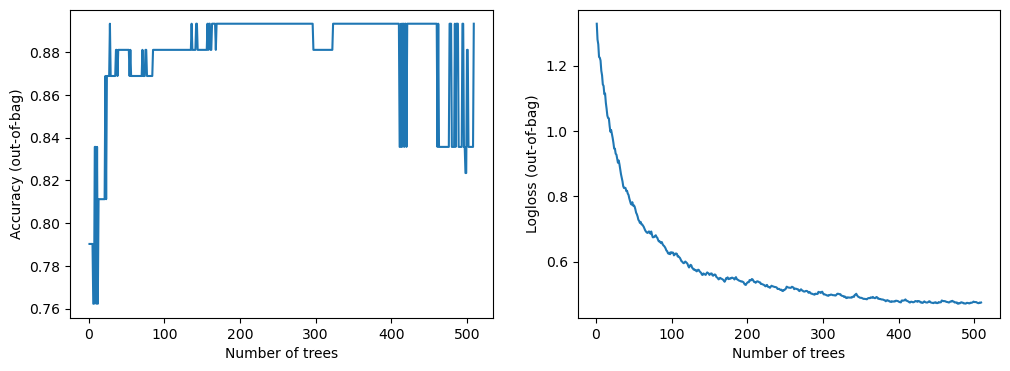


Train: 0.3734 Validation: 0.3298
##### Fold 3
Use /tmp/tmpigcz02n3 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:21:26.3180 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:26.3180 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:26.3180 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.141403. Found 555 examples.
Training model...
Model trained in 0:00:01.644547
Compiling model...


[INFO 23-07-29 20:21:29.0939 UTC kernel.cc:1242] Loading model from path /tmp/tmpigcz02n3/model/ with prefix 6c6b6d37ce0749f8
[INFO 23-07-29 20:21:29.1122 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:21:29.1122 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 241ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.1800


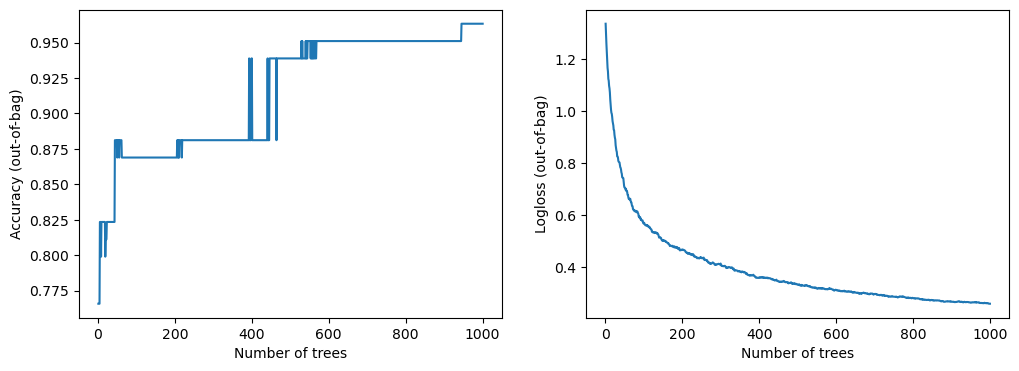


Train: 0.4286 Validation: 0.1800
##### Fold 4
Use /tmp/tmp4r1ug_if as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:21:31.5158 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:31.5159 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:31.5159 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.045123. Found 555 examples.
Training model...
Model trained in 0:00:00.425517
Compiling model...


[INFO 23-07-29 20:21:33.0024 UTC kernel.cc:1242] Loading model from path /tmp/tmp4r1ug_if/model/ with prefix b7b963f319734e81
[INFO 23-07-29 20:21:33.0067 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 234ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2218


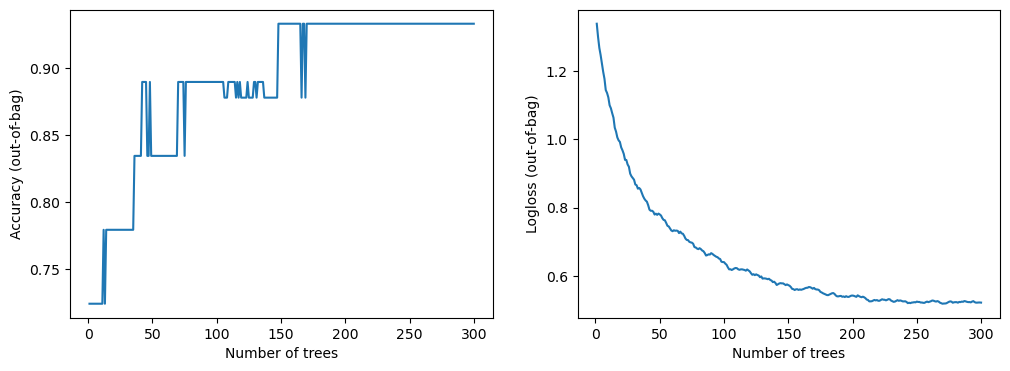


Train: 0.3504 Validation: 0.2218
##### Fold 5
Use /tmp/tmpfzipg17d as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:21:35.3372 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:35.3373 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:35.3373 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.037537. Found 555 examples.
Training model...
Model trained in 0:00:00.575624
Compiling model...


[INFO 23-07-29 20:21:36.9532 UTC kernel.cc:1242] Loading model from path /tmp/tmpfzipg17d/model/ with prefix 0af6b8cdeb1f48d5
[INFO 23-07-29 20:21:36.9586 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 238ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2437


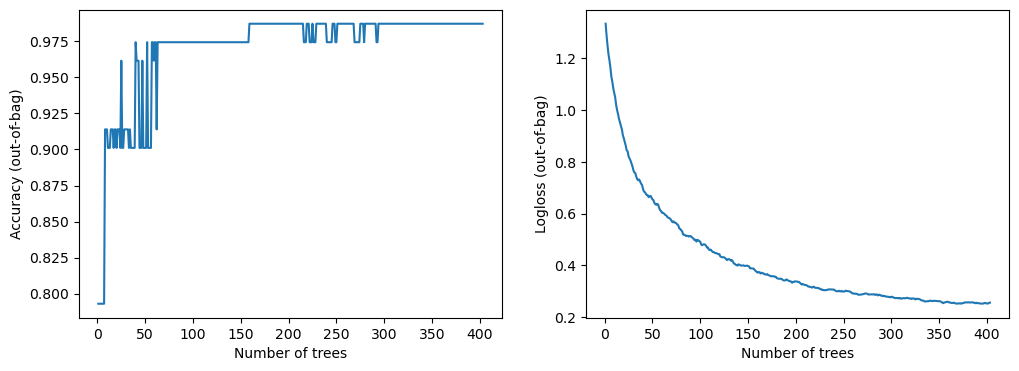


Train: 0.3695 Validation: 0.2437
##### Fold 6
Use /tmp/tmptzqe8485 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:21:39.1958 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:39.1958 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:39.1959 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.046064. Found 555 examples.
Training model...
Model trained in 0:00:00.680984
Compiling model...


[INFO 23-07-29 20:21:40.9247 UTC kernel.cc:1242] Loading model from path /tmp/tmptzqe8485/model/ with prefix 0c07db275c754b96
[INFO 23-07-29 20:21:40.9310 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:21:40.9311 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 238ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2334


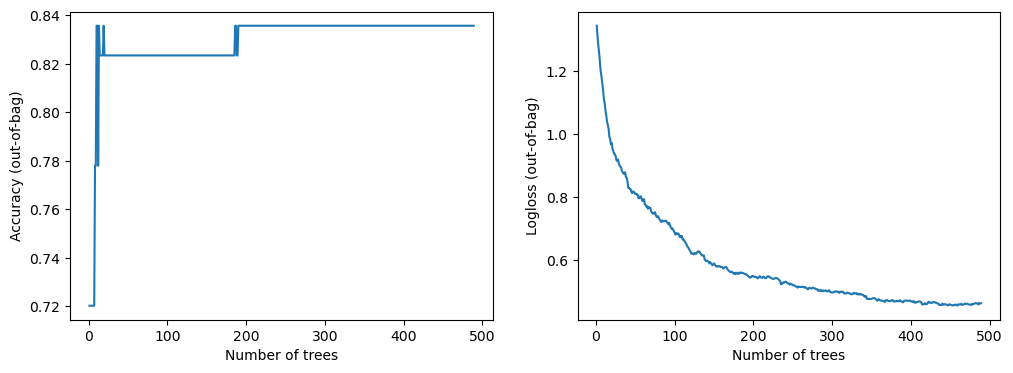


Train: 0.3818 Validation: 0.2334
##### Fold 7
Use /tmp/tmpmgq5a2fp as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:21:44.3435 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:44.3437 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:44.3437 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.039803. Found 555 examples.
Training model...
Model trained in 0:00:00.678893
Compiling model...


[INFO 23-07-29 20:21:46.0649 UTC kernel.cc:1242] Loading model from path /tmp/tmpmgq5a2fp/model/ with prefix 58c7b896e9da4cb5
[INFO 23-07-29 20:21:46.0707 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 237ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1783


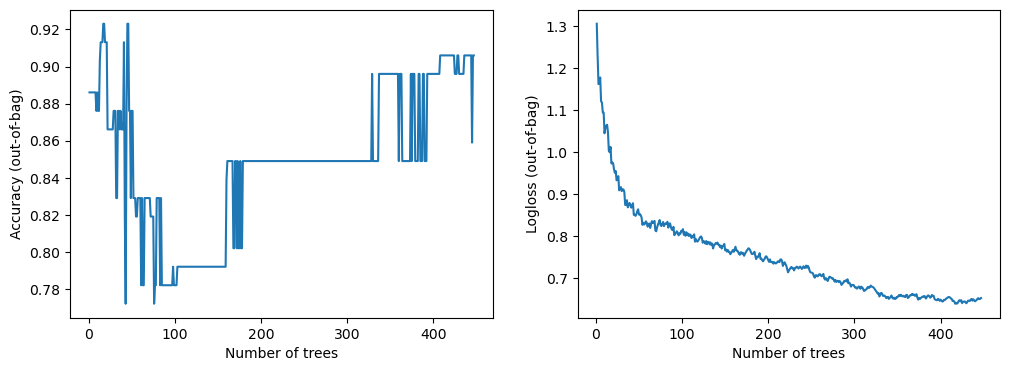


Train: 0.3857 Validation: 0.1783
##### Fold 8
Use /tmp/tmpakpj1ric as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:21:49.5250 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:49.5250 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:49.5251 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.071796. Found 556 examples.
Training model...
Model trained in 0:00:00.713927
Compiling model...


[INFO 23-07-29 20:21:51.3125 UTC kernel.cc:1242] Loading model from path /tmp/tmpakpj1ric/model/ with prefix bdbe0be04dcd4bf7
[INFO 23-07-29 20:21:51.3189 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 20:21:51.3190 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 239ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.1534


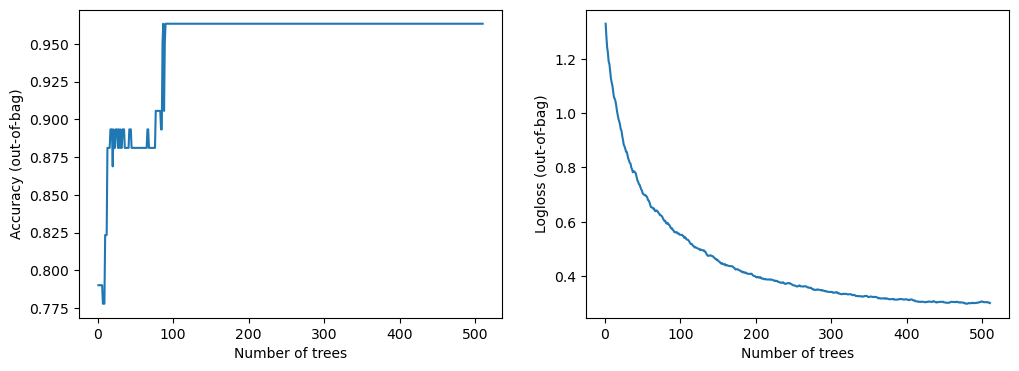


Train: 0.3152 Validation: 0.1534
##### Fold 9
Use /tmp/tmpc2eh45ia as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:21:53.4900 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:53.4900 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:53.4900 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.049772. Found 556 examples.
Training model...
Model trained in 0:00:00.793390
Compiling model...


[INFO 23-07-29 20:21:55.3339 UTC kernel.cc:1242] Loading model from path /tmp/tmpc2eh45ia/model/ with prefix e3b6452e44754651
[INFO 23-07-29 20:21:55.3411 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 244ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3722


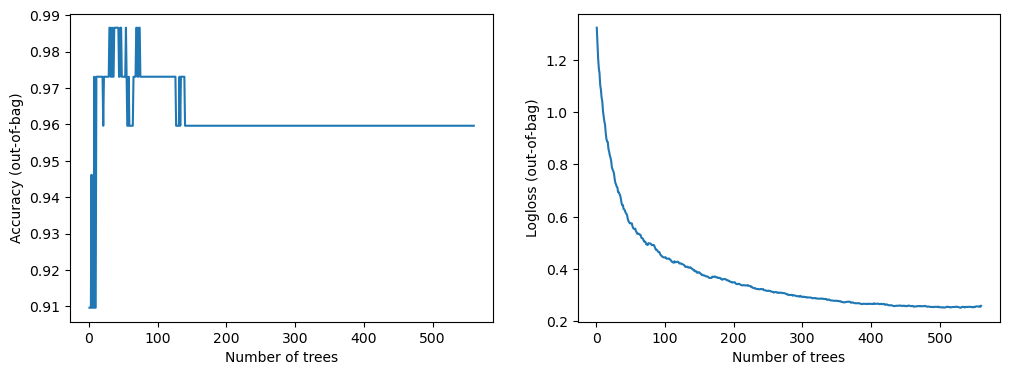


Train: 0.2672 Validation: 0.3722
##### Fold 10
Use /tmp/tmpvzoj46za as temporary training directory
Reading training dataset...


[WARNING 23-07-29 20:21:57.4611 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:57.4611 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 20:21:57.4611 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.031631. Found 556 examples.
Training model...
Model trained in 0:00:00.644090
Compiling model...


[INFO 23-07-29 20:21:59.1394 UTC kernel.cc:1242] Loading model from path /tmp/tmpvzoj46za/model/ with prefix bcd5604cb50d411e
[INFO 23-07-29 20:21:59.1451 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 368ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9836 - balanced_log_loss: 0.1415


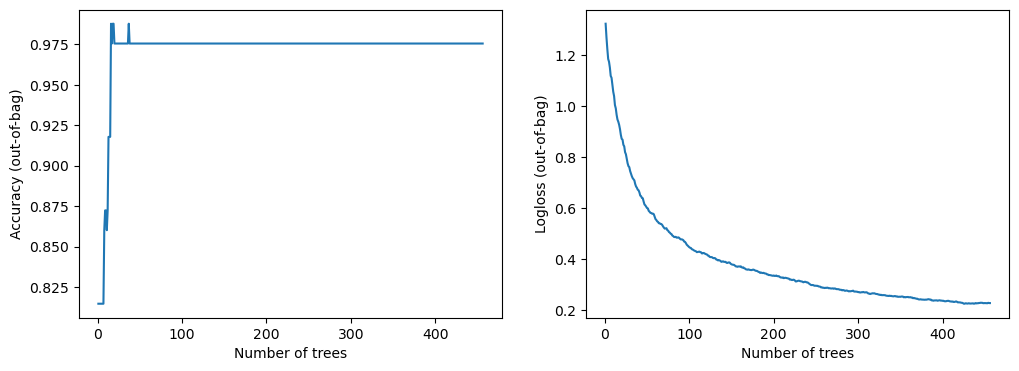


Train: 0.5158 Validation: 0.1415

Train mean: 0.3498 std: 0.1066

Validation mean: 0.2301 std: 0.0742
1/1 [==============================] - 0s 126ms/step


In [15]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_GBT_2 = TFDF_CV_Ensemble(model_obj=tfdf.keras.GradientBoostedTreesModel, label="Class")

# train
CV_Ensemble_GBT_2 = CV_Ensemble_GBT_2.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=2, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_GBT_2.save(save_path='/kaggle/working/GBT/2')

# Collect attributes and predictions

train_summary_gbt_2 = CV_Ensemble_GBT_2.X_summary
valid_summary_gbt_2 = CV_Ensemble_GBT_2.valid_summary
test_summary_gbt_2 = CV_Ensemble_GBT_2.predict(X=test_out)
model_gbt_2 = CV_Ensemble_GBT_2.models
metrics_gbt_2 = CV_Ensemble_GBT_2.metrics

# TabPFN

In [16]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    
    # Correct Values
    min_val = 1e-15
    max_val = 0.999999999999999

    y_pred = np.minimum(y_pred, [max_val])
    y_pred = np.maximum(y_pred, [min_val])
    
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

def train_model_tabpfn_one(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    test_summary = pd.DataFrame(data=np.full((len(test.index),1), np.nan),index=test.index)
    train_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_test = model.predict_proba(test[features])[:,1]

    # Predict value for validation/Submition data
    test_summary[0] = p_test.flatten() 
    train_summary[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
    metrics['balanced_logloss'] = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    print(f"\nTrain: {metrics['balanced_logloss']:.4f}")
    
            
    return train_summary, test_summary, model, metrics

class TabPFN_CV_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, model_obj = TabPFNClassifier, label = "Class"):
        self.label: str = label
        self.model_obj = model_obj
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.valid_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list()
        self.models: dict = dict()
        self.metrics: dict = dict()
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, features: list, splitter = StratifiedKFold(),
            model_kwargs = dict(N_ensemble_configurations=64)):
        
        # Case CV Ensmble
        # TODO: Case of N_ensemble_configurations
        
        n_splits = splitter.get_n_splits()

        # Create a various frames
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan), index=X.index) # For In-Sample Predictions of each Fold
        self.valid_summary = pd.DataFrame(data=np.full((len(X.index),1), np.nan), index=X.index) # For Out-of-Sample Prediction of each Fold
        self.features: list = features
        
        # Create an empty dictionary to store the models Xed for each fold.
        self.models = {}
        self.metrics = {}
        balanced_logloss_train = {}
        balanced_logloss_val = {}

        class_weight: dict = self._compute_weights(X)
        
        for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X[self.label])):
            print('##### Fold',i)
            # Fetch values corresponding to the index 
            train_df = X.iloc[train_index]
            valid_df = X.iloc[valid_index]
            train_ids = train_df.index.values
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[self.features+[self.label]]
            valid_df = valid_df[self.features+[self.label]]

            # Define & Train the model
            model = self.model_obj(**model_kwargs)
            model.fit(train_df[self.features],train_df[self.label])

            # Store the model
            self.models[i] = model

            # Predict value for validation/Submition data
            p_train = model.predict_proba(train_df[self.features])[:,1]
            p_val = model.predict_proba(valid_df[self.features])[:,1]

            # Predict Values
            self.X_summary.loc[train_ids, i] = p_train
            self.valid_summary.loc[valid_ids, 0] = p_val

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[self.label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[self.label].values,y_pred=p_val)

            balanced_logloss_train[i] = train_metric
            balanced_logloss_val[i] = val_metric

            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
        self.metrics['train'] = balanced_logloss_train
        self.metrics['val'] = balanced_logloss_val

        print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
        print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n_splits = len(self.models)
        X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan),index=X.index) # For X (Sumbition) Predictions of each Fold's Model

        for i, model in enumerate(self.models.values()):
            X_summary[i] = model.predict_proba(X[self.features])[:,1]
        
        return X_summary
    
    def save(self, save_path: str) -> None:
        try:
            shutil.rmtree(save_path)
        except FileNotFoundError:
            pass
        else:
            pass
            
        os.makedirs(f'{save_path}/models', exist_ok=True)
        
        for fold, model in self.models.items():
            joblib.dump(value=model, filename=f'{save_path}/models/{fold}.pickle')
        
        joblib.dump(value=self.label, filename=f'{save_path}/label.pickle')
        joblib.dump(value=self.model_obj, filename=f'{save_path}/model_obj.pickle')
        
        joblib.dump(value=self.X_summary, filename=f'{save_path}/X_summary.pickle')
        joblib.dump(value=self.valid_summary, filename=f'{save_path}/valid_summary.pickle')
        joblib.dump(value=self.features, filename=f'{save_path}/features.pickle')
        joblib.dump(value=self.metrics, filename=f'{save_path}/metrics.pickle')
            
        return None
    
    def load(self, save_path: str):
        
        self.label = joblib.load(filename=f'{save_path}/label.pickle')
        self.model_obj = joblib.load(filename=f'{save_path}/model_obj.pickle')
        
        self.X_summary = joblib.load(filename=f'{save_path}/X_summary.pickle')
        self.valid_summary = joblib.load(filename=f'{save_path}/valid_summary.pickle')
        self.features = joblib.load(filename=f'{save_path}/features.pickle')
        self.metrics = joblib.load(filename=f'{save_path}/metrics.pickle')
        
        self.models = dict()
        
        for name in os.listdir(f'{save_path}/models'):
            i = name.split('.')[0]
            self.models[int(i)] = joblib.load(filename=f'{save_path}/models/{name}')
            
        return self

Before
```python
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,test=test_out, features=features_slice, n_splits=6)
```

In [17]:
%%time
# TabPFN tabpfn_

features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_1, test_summary_tabpfn_1, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
    train=train_out,test=test_out, features=features_slice)

os.makedirs('/kaggle/working/TabPFN/1',exist_ok=True)
joblib.dump(value=model_tabpfn_1, filename='/kaggle/working/TabPFN/1/1.pickle')

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0515
CPU times: user 1min 41s, sys: 44.2 s, total: 2min 26s
Wall time: 2min 26s


['/kaggle/working/TabPFN/1/1.pickle']

In [18]:
%%time
# TabPFN
features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=6,shuffle=True, random_state=1902)

# initialise
TabPFN_CV_Ensemble_2 = TabPFN_CV_Ensemble(model_obj = TabPFNClassifier, label = "Class")

# train
TabPFN_CV_Ensemble_2 = TabPFN_CV_Ensemble_2.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs = dict(N_ensemble_configurations=64))

# save
TabPFN_CV_Ensemble_2.save(save_path='/kaggle/working/TabPFN/2')

# Collect attributes and predictions

train_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.X_summary
valid_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.valid_summary
test_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.predict(X=test_out)
model_tabpfn_2 = TabPFN_CV_Ensemble_2.models
metrics_tabpfn_2 = TabPFN_CV_Ensemble_2.metrics

# for inference load

# TabPFN_CV_Ensemble_2_load = TabPFN_CV_Ensemble(model_obj = TabPFNClassifier, label = "Class")

# TabPFN_CV_Ensemble_2_load = TabPFN_CV_Ensemble_2_load.load(save_path='/kaggle/working/TabPFN/2')


# train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
#     train=train_out,test=test_out, features=features_slice, n_splits=6)

##### Fold 0
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0591 Validation: 0.1325
##### Fold 1
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0528 Validation: 0.3273
##### Fold 2
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0505 Validation: 0.3091
##### Fold 3
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0511 Validation: 0.2504
##### Fold 4
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0512 Validation: 0.2377
##### Fold 5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0519 Validation: 0.4155

Train mean: 0.0528 std: 0.0032

Validation mean: 0.2788 std: 0.0958
CPU times: user 11min 29s, sys: 4min 48s, total: 16min 18s
Wall time: 16min 19s


# Ensemble CV

Idea to create Entity that can accept multiple previously fitted Regressors and then create final estimate.

In [19]:
class Diff_Class_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, label = "Class"):
        self.label: str = label
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list() # Shall be Union of all features
        self.models: dict = dict() # Each Feature is a scikit-learn compatible & fitted
        self.metrics: dict = dict()
        self.weights: np.ndarray = None
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, 
            models: list, weights: np.ndarray, # List of Estimated Regressors 
            splitter = StratifiedKFold()):
        
        # Count how many sub models we have 
        n_models = len(models)
        self.models = dict()
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_models), np.nan), index=X.index) # For In-Sample Predictions of each Fold
     
        # Make Estimations
        for i,model in enumerate(models):
            X_predicted: pd.DataFrame = model.predict(X) # Shall have original features, which would be checked in DF X
            X_predicted: pd.Series = X_predicted.mean(axis=1)
            self.X_summary[i] = X_predicted
            self.models[i] = model
            self.features = self.features + model.features
        
        # To omit duplications
        self.features: list = list(set(self.features))
        
        # Compute Metrics for each weight combinations
        self.metrics = {}
        for weight in weights:
            #weight = weight.reshape(2,1)
            weight_hash = tuple(weight) #.tolist()
            weight_1D = weight.reshape(-1,1)
            
            self.metrics[weight_hash] = dict(train=list(),valid=list())
            
            for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X[self.label])):
                # Fetch values corresponding to the index 
                train_df: np.ndarray = self.X_summary.iloc[train_index].values
                valid_df: np.ndarray = self.X_summary.iloc[valid_index].values

                # Predict value for validation/Submition data
                p_train = train_df.dot(weight_1D)
                p_val = valid_df.dot(weight_1D)

                y_train_true: pd.Series = X.iloc[train_index][self.label].values
                y_valid_true: pd.Series = X.iloc[valid_index][self.label].values

                # Evaluate and store the metrics in respective dicts
                train_metric = balanced_logloss_np(y_true=y_train_true,y_pred=p_train)
                val_metric = balanced_logloss_np(y_true=y_valid_true,y_pred=p_val)

                self.metrics[weight_hash]['train'].append(train_metric)
                self.metrics[weight_hash]['valid'].append(val_metric)
            
            self.metrics[weight_hash]['train_mean'] = np.mean(self.metrics[weight_hash]['train'])
            self.metrics[weight_hash]['train_std'] = np.std(self.metrics[weight_hash]['train'])
            self.metrics[weight_hash]['valid_mean'] = np.mean(self.metrics[weight_hash]['valid'])
            self.metrics[weight_hash]['valid_std'] = np.std(self.metrics[weight_hash]['valid'])
            
        # TODO: Some Logic
        self.weights: np.ndarray = weights[0,:].reshape(-1,1)
            
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n_models = len(self.models)
        Y_Preds = pd.DataFrame(data=np.full((len(X.index),n_models), np.nan),
                               index=X.index)

        for i, model in enumerate(self.models.values()):
            Y_Preds[i] = model.predict(X).mean(axis=1)
            
        Y_Preds: np.ndarray = Y_Preds.values
        
        y_pred = Y_Preds.dot(self.weights)
        
        return y_pred

# Initialise

Diff_Class_Ensemble_3Class = Diff_Class_Ensemble(label='Class')

# Fit 
my_splitter = StratifiedKFold(n_splits=3,shuffle=True, random_state=1902)

# Weights
my_weights = list(itertools.permutations(iterable=np.linspace(0., 1., 21), r=3))
my_weights = [i for i in my_weights if round(sum(i),4) == 1]
my_weights = [i for i in my_weights if round(min(i),4) >= .15]

my_weights = np.array(my_weights)


Diff_Class_Ensemble_3Class = Diff_Class_Ensemble_3Class.fit(X=train_out,
                                                            models = [CV_Ensemble_GBT_2, 
                                                                      CV_Ensemble_3,
                                                                     TabPFN_CV_Ensemble_2], 
                                                            splitter = my_splitter,
                                                            weights = my_weights)

1/1 [==============================] - 0s 157ms/step


In [20]:
pd.DataFrame(Diff_Class_Ensemble_3Class.metrics).T

train  \
0.15 0.20 0.65  [0.10556868611201618, 0.10202163695194662, 0.0...   
     0.25 0.60  [0.11155219050574758, 0.10818623501461352, 0.1...   
     0.30 0.55  [0.11763329076227116, 0.11445441071264968, 0.1...   
     0.35 0.50  [0.12381665258694563, 0.12083135345955036, 0.1...   
     0.40 0.45  [0.1301074276790997, 0.1273228241450949, 0.120...   
     0.45 0.40  [0.13651133128530205, 0.13393525929677044, 0.1...   
     0.50 0.35  [0.14303473793693638, 0.1406759034420662, 0.13...   
     0.55 0.30  [0.14968480111900012, 0.14755298018030977, 0.1...   
     0.60 0.25  [0.15646960500129875, 0.1545759176328544, 0.14...   
     0.65 0.20  [0.16339836000941318, 0.1617556523490032, 0.15...   
0.20 0.15 0.65  [0.10185481016416653, 0.09918361669551848, 0.0...   
     0.25 0.55  [0.11381855224011447, 0.11153733382515879, 0.1...   
     0.30 0.50  [0.11994855522949424, 0.11787324422795992, 0.1...   
     0.35 0.45  [0.12618379793132178, 0.12432264666617669, 0.1...   
     0.45 0.35  [0.1389927333066933, 0.13758844204378168, 0.12...   
     0.50 0.30  [0.14557949498859504, 0.1444203294023157, 0.13...   
     0.55 0.25  [0.15229789665738203, 0.15139711534623015, 0.1...   
     0.65 0.15  [0.16616653582240848, 0.16583162031625648, 0.1...   
0.25 0.15 0.60  [0.10408550116892981, 0.10248389185736631, 0.0...   
     0.20 0.55  [0.11006601264810065, 0.10867370469541071, 0.1...   
     0.30 0.45  [0.12232716474302902, 0.1213797209209237, 0.11...   
     0.35 0.40  [0.12861799787415532, 0.1279080915679063, 0.12...   
     0.40 0.35  [0.1350234323783379, 0.13456279250824293, 0.12...   
     0.45 0.30  [0.1415501750260506, 0.14135213517411033, 0.13...   
     0.55 0.20  [0.1549989707003009, 0.15537478291914233, 0.14...   
     0.60 0.15  [0.16193961996379758, 0.16263269746940406, 0.1...   
0.30 0.15 0.55  [0.10637396202582843, 0.10586271977018685, 0.1...   
     0.20 0.50  [0.11240401661367175, 0.1121219668361206, 0.10...   
     0.25 0.45  [0.11853554564643118, 0.11849312046125975, 0.1...   
     0.45 0.25  [0.14419058196592618, 0.1452405209519019, 0.13...   
     0.50 0.20  [0.15092175889288334, 0.15228915889572575, 0.1...   
     0.55 0.15  [0.15779759953722838, 0.15950694077200325, 0.1...   
0.35 0.15 0.50  [0.10872406484698341, 0.10932718735111639, 0.1...   
     0.20 0.45  [0.11480714334879308, 0.11566204618859047, 0.1...   
     0.25 0.40  [0.12099518258312289, 0.12211478440419207, 0.1...   
     0.40 0.25  [0.14024976154246693, 0.1422605171100977, 0.13...   
     0.45 0.20  [0.14692251841751897, 0.1492719408230661, 0.13...   
     0.50 0.15  [0.1537375495830414, 0.15645328799220287, 0.14...   
0.40 0.15 0.45  [0.11114033191662748, 0.11288582160188096, 0.1...   
     0.25 0.35  [0.12352966154402831, 0.12584687216881135, 0.1...   
     0.35 0.25  [0.13638115300274747, 0.13934490407503267, 0.1...   
     0.45 0.15  [0.14975689719762172, 0.15347095008746187, 0.1...   
0.45 0.15 0.40  [0.11362812076743298, 0.11654906496042151, 0.1...   
     0.20 0.35  [0.11983016414298528, 0.1230594030878262, 0.11...   
     0.25 0.30  [0.12614602154811344, 0.12970387782800236, 0.1...   
     0.30 0.25  [0.1325828113498097, 0.13649307533300387, 0.12...   
     0.35 0.20  [0.13914873845778972, 0.14343971265752434, 0.1...   
     0.40 0.15  [0.1458533941923234, 0.15055941310173376, 0.13...   
0.50 0.15 0.35  [0.11619389095510126, 0.12032997789464524, 0.1...   
     0.20 0.30  [0.12246363897373344, 0.12694446129711806, 0.1...   
     0.30 0.20  [0.13537027932132695, 0.14062377923526398, 0.1...   
     0.35 0.15  [0.14202509710431643, 0.1477184478515779, 0.13...   
0.55 0.15 0.30  [0.11884560427654658, 0.12424531760624624, 0.1...   
     0.20 0.25  [0.1251902978145023, 0.13097934965708374, 0.12...   
     0.25 0.20  [0.13166192206284946, 0.13787442170476125, 0.1...   
     0.30 0.15  [0.13827035402552304, 0.14494812868916868, 0.1...   
0.60 0.15 0.25  [0.12159335539792937, 0.12831727210539742, 0.1...   
     0.25 0.15  [0.1345877980927459, 0.1422488635087828, 0

I choose wieghts (manually):
0.35	0.15	0.50

In [21]:
Diff_Class_Ensemble_3Class.weights

array([[0.15],
       [0.2 ],
       [0.65]])

In [22]:
Manual_Best_Weights = np.array([[0.35],[0.15],[0.50]]) # Manual_Best_Weights
Manual_Best_Weights

array([[0.35],
       [0.15],
       [0.5 ]])

In [23]:
Diff_Class_Ensemble_3Class.weights = Manual_Best_Weights

# Cut-Offs

In [24]:
ensemble_final_train_out = Diff_Class_Ensemble_3Class.predict(X=train_out)
# ensemble_final_train_out

1/1 [==============================] - 0s 157ms/step


In [25]:
ensemble_final_test_out = Diff_Class_Ensemble_3Class.predict(X=test_out)
# ensemble_final_test_out

1/1 [==============================] - 0s 134ms/step


In [26]:
train_out['Y_Pred'] = ensemble_final_train_out

In [27]:
def compute_cut_off(y_pred: pd.Series, y_true: pd.Series) -> pd.DataFrame:
    # Let's try to find Cutoffs organically
    y_pred.name = 'Pred'
    y_true.name = 'Class'

    tmp = pd.concat([y_pred, y_true], axis=1).sort_index(ascending=True)

    tmp['Pred_Bins'] = pd.qcut(x=tmp['Pred'],q=100)
    tmp = tmp.groupby('Pred_Bins')['Class'].agg({'sum','count'})
    tmp['count_cumsum'] = tmp['count'].cumsum()
    tmp['sum_cumsum'] = tmp['sum'].cumsum()

    tmp['bads_rate'] = tmp['sum_cumsum']/tmp['count_cumsum']

    tmp['perc_sum'] = [*range(1,101)]

    return tmp

cut_off_df = compute_cut_off(y_pred=train_out['Y_Pred'], y_true=train_out['Class'])

cut_off_df

,sum,count,count_cumsum,sum_cumsum,bads_rate,perc_sum
Pred_Bins,,,,,,
"(-0.000779, 0.00181]",0,7,7,0,0.000000,1
"(0.00181, 0.00245]",0,6,13,0,0.000000,2
"(0.00245, 0.00288]",0,6,19,0,0.000000,3
"(0.00288, 0.00308]",0,6,25,0,0.000000,4
"(0.00308, 0.00368]",0,6,31,0,0.000000,5
"(0.00368, 0.00402]",0,6,37,0,0.000000,6
"(0.00402, 0.00461]",0,7,44,0,0.000000,7
"(0.00461, 0.00563]",0,6,50,0,0.000000,8
"(0.00563, 0.00613]",0,6,56,0,0.000000,9


Manually I choose:
* Lower 0.205 -> to 0
* Upper 0.711 -> to 1

In [28]:
# Lower
train_out['Y_Pred_After_CutOff'] = np.where(train_out['Y_Pred'] <= 0.205,0,train_out['Y_Pred'])

# Upper
train_out['Y_Pred_After_CutOff'] = np.where(train_out['Y_Pred'] >= 0.711,1,train_out['Y_Pred'])

In [29]:
print('Before')
print(balanced_logloss_np(y_pred=train_out['Y_Pred'].values,y_true=train_out['Class'].values))
print('After')
print(balanced_logloss_np(y_pred=train_out['Y_Pred_After_CutOff'].values,y_true=train_out['Class'].values))

Before
0.10725016159931122
After
0.06370857606976135


In [30]:
test_out['Y_Pred'] = ensemble_final_test_out # ensemble_final_test_out = Diff_Class_Ensemble_3Class.predict(X=test_out)

# Lower
test_out['Y_Pred_After_CutOff'] = np.where(test_out['Y_Pred'] <= 0.205,0,test_out['Y_Pred'])

# Upper
test_out['Y_Pred_After_CutOff'] = np.where(test_out['Y_Pred'] >= 0.711,1,test_out['Y_Pred'])

In [31]:
test_out

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FS_na,CC_na,FL_na,GL_na,CB_na,EL_na,BQ_na,EJ_A,Y_Pred,Y_Pred_After_CutOff
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,-1.770874,...,0,0,0,0,0,0,0,1,0.593122,0.593122
010ebe33f668,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,-1.770874,...,0,0,0,0,0,0,0,1,0.593122,0.593122
02fa521e1838,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,-1.770874,...,0,0,0,0,0,0,0,1,0.593122,0.593122
040e15f562a2,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,-1.770874,...,0,0,0,0,0,0,0,1,0.593122,0.593122
046e85c7cc7f,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,-1.770874,...,0,0,0,0,0,0,0,1,0.593122,0.593122


# Submission

In [32]:
# submition_total
submition_total = test_out[['Y_Pred_After_CutOff']].copy()
submition_total['class_1'] = submition_total['Y_Pred_After_CutOff']
submition_total['class_0'] = 1 - submition_total['class_1']
submition_total = submition_total[['class_0','class_1']].copy()
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

In [33]:
submition_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 00eed32682bb to 046e85c7cc7f
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   class_0  5 non-null      float64
 1   class_1  5 non-null      float64
dtypes: float64(2)
memory usage: 120.0+ bytes
